# Import necessary libraries

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import os
from collections import Counter
import time
import spacy
from tqdm.auto import tqdm
import ast
from math import pi

# Configuration

In [9]:
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
RAW_DATA_PATH = os.path.join(BASE_DIR, 'data', 'raw', 'NEW.csv')
PROCESSED_DATA_PATH = os.path.join(BASE_DIR, 'data', 'processed', 'processed_NEW.csv')
ROEMOLEX_WORDS_PATH = os.path.join(BASE_DIR, 'data', 'external', 'roemolex', 'RoEmoLex_V3_pos (sept2021).csv')
ROEMOLEX_EXPR_PATH = os.path.join(BASE_DIR, 'data', 'external', 'roemolex', 'RoEmoLex_V3_expr (sept2021).csv')
VISUALIZATIONS_DIR = os.path.join(BASE_DIR, 'visualizations', 'dataset_analysis')
BASIC_ANALYSIS_DIR = os.path.join(VISUALIZATIONS_DIR, 'basic_analysis')
LEXICAL_ANALYSIS_DIR = os.path.join(VISUALIZATIONS_DIR, 'lexical_analysis')
POS_DIR = os.path.join(VISUALIZATIONS_DIR, 'pos')
NER_DIR = os.path.join(VISUALIZATIONS_DIR, 'ner')
WORDCLOUD_DIR = os.path.join(VISUALIZATIONS_DIR, 'word_clouds')
EMOTION_DIR = os.path.join(VISUALIZATIONS_DIR, 'emotion_analysis')
EMOTIONAL_WORDCLOUD_DIR = os.path.join(EMOTION_DIR, 'emotional_wordclouds')

os.makedirs(VISUALIZATIONS_DIR, exist_ok=True)
os.makedirs(BASIC_ANALYSIS_DIR, exist_ok=True)
os.makedirs(LEXICAL_ANALYSIS_DIR, exist_ok=True)
os.makedirs(POS_DIR, exist_ok=True)
os.makedirs(NER_DIR, exist_ok=True)
os.makedirs(WORDCLOUD_DIR, exist_ok=True)
os.makedirs(EMOTION_DIR, exist_ok=True)
os.makedirs(EMOTIONAL_WORDCLOUD_DIR, exist_ok=True)

# Load Dataset

In [3]:
print(f"\nLoading dataset from: {RAW_DATA_PATH}")
try:
    df = pd.read_csv(RAW_DATA_PATH)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"Error: Dataset file not found at {RAW_DATA_PATH}")
    exit()


Loading dataset from: C:\Users\Razvan\projects\university\romanian-fake-news-detection\data\raw\NEW.csv
Dataset loaded successfully.


In [35]:
print("\n--- Initial Dataset Info ---")
print(f"Shape: {df.shape}")
print("\nColumns:", df.columns.tolist())
print("\nData types:\n", df.dtypes)
print("\nFirst 5 rows:\n", df.head())
print("\nMissing values:\n", df.isnull().sum())


--- Initial Dataset Info ---
Shape: (5160, 2)

Columns: ['content', 'tag']

Data types:
 content    object
tag        object
dtype: object

First 5 rows:
                                              content             tag
0  atacul iudeilor asupra libertății de exprimare...       fake_news
1  planurile autorităților moldovenești de organi...  misinformation
2  transfuziile cu sânge care provin de la persoa...       fake_news
3  operațiunea militară specială este nouă etapă ...      propaganda
4  joe biden declarat cea mai sfântă dintre sărbă...  misinformation

Missing values:
 content    0
tag        0
dtype: int64


#### Define categories

In [79]:
categories = df['tag'].unique()
print(f"\nExpected categories: {categories}")


Expected categories: ['fake_news' 'misinformation' 'propaganda' 'real_news' 'satire']


#### Dataset Description

In [80]:
print("\n--- Dataset Description ---")
print(f"Initial size: {df.shape[0]} rows, {df.shape[1]} columns")

print("\nCategory distribution (counts):")
category_counts = df['tag'].value_counts()
print(category_counts)

print("\nCategory distribution (percentages):")
category_percentages = df['tag'].value_counts(normalize=True) * 100
print(category_percentages)


--- Dataset Description ---
Initial size: 5160 rows, 2 columns

Category distribution (counts):
tag
fake_news         1032
misinformation    1032
propaganda        1032
real_news         1032
satire            1032
Name: count, dtype: int64

Category distribution (percentages):
tag
fake_news         20.0
misinformation    20.0
propaganda        20.0
real_news         20.0
satire            20.0
Name: proportion, dtype: float64



Saved category distribution plot to C:\Users\Razvan\projects\university\romanian-fake-news-detection\visualizations\dataset_analysis\basic_analysis


C:\Users\Razvan\AppData\Local\Temp\ipykernel_12212\594897612.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis", legend=False)


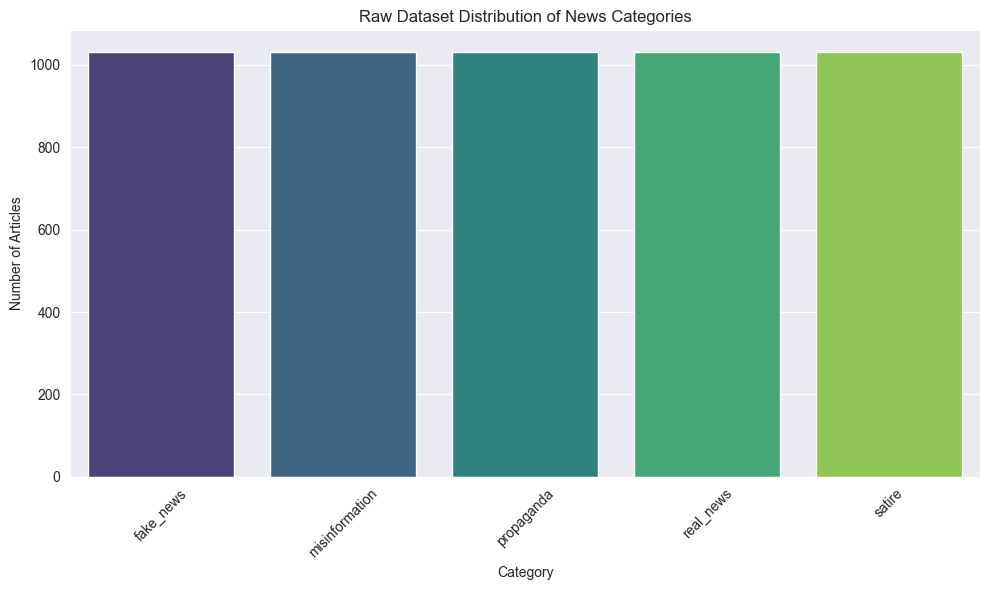

In [81]:
plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis", legend=False)
plt.title('Raw Dataset Distribution of News Categories')
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(BASIC_ANALYSIS_DIR, 'raw_dataset_category_distribution.png'))
print(f"\nSaved category distribution plot to {BASIC_ANALYSIS_DIR}")

# Initial cleaning

In [82]:
print("\n--- Initial Cleaning ---")
print(f"Dataset size before cleaning: {len(df)}")

initial_rows = len(df)
df.drop_duplicates(subset=['content'], keep='first', inplace=True)
rows_after_duplicates = len(df)
print(f"Removed {initial_rows - rows_after_duplicates} duplicate articles based on 'content'.")
print(f"Dataset size after removing duplicates: {len(df)}")

MIN_CONTENT_LENGTH = 50
initial_rows_before_len_filter = len(df)
df = df[df['content'].str.len() >= MIN_CONTENT_LENGTH]
rows_after_len_filter = len(df)
print(f"Removed {initial_rows_before_len_filter - rows_after_len_filter} articles with content length < {MIN_CONTENT_LENGTH} characters.")
print(f"Final dataset size after initial cleaning: {len(df)}")

print("\nCategory distribution after cleaning:")
print(df['tag'].value_counts())
print("\nCategory distribution (percentages) after cleaning:")
print(df['tag'].value_counts(normalize=True) * 100)

df.reset_index(drop=True, inplace=True)


--- Initial Cleaning ---
Dataset size before cleaning: 5160
Removed 819 duplicate articles based on 'content'.
Dataset size after removing duplicates: 4341
Removed 7 articles with content length < 50 characters.
Final dataset size after initial cleaning: 4334

Category distribution after cleaning:
tag
real_news         1032
misinformation     916
satire             870
fake_news          812
propaganda         704
Name: count, dtype: int64

Category distribution (percentages) after cleaning:
tag
real_news         23.811721
misinformation    21.135210
satire            20.073835
fake_news         18.735579
propaganda        16.243655
Name: proportion, dtype: float64

Initial cleaning complete.


# Load spaCy Romanian Model

In [ ]:
# python -m spacy download ro_core_news_lg
!pip install spacy

In [36]:
import spacy

SPACY_MODEL_NAME = "ro_core_news_lg"

print(f"\n--- Loading spaCy model: {SPACY_MODEL_NAME} ---")
try:
    nlp = spacy.load(SPACY_MODEL_NAME, disable=[]) # Load all components
    print(f"spaCy model '{SPACY_MODEL_NAME}' loaded successfully.")
except OSError:
    print(f"Error: spaCy model '{SPACY_MODEL_NAME}' not found.")
    print(f"Please download it by running: python -m spacy download {SPACY_MODEL_NAME}")
    nlp = None
except Exception as e:
    print(f"An unexpected error occurred loading the spaCy model: {e}")
    nlp = None

if nlp:
    print(f"\n--- Applying spaCy Preprocessing ---")
    print("This may take a while...")

    tqdm.pandas(desc="spaCy Processing")

    processed_docs = []
    batch_size = 100
    start_time = time.time()

    for doc in tqdm(nlp.pipe(df['content'], batch_size=batch_size), total=len(df), desc="Processing Texts"):
        lemmas_filtered = [
            token.lemma_.lower() for token in doc
            if not token.is_stop 
            and not token.is_punct 
            and token.is_alpha
            and token.pos_ not in {"ADP", "CCONJ", "SCONJ"}
        ]
        all_lemmas = [token.lemma_.lower() for token in doc]
        pos_tags = [token.pos_ for token in doc]
        entities = [(ent.text, ent.label_) for ent in doc.ents]

        processed_docs.append({
            'lemmas_filtered': lemmas_filtered,
            'all_lemmas': all_lemmas,
            'pos_tags': pos_tags,
            'entities': entities
        })

    end_time = time.time()
    print(f"spaCy processing finished in {end_time - start_time:.2f} seconds.")

    print("\nAdding processed columns to DataFrame...")
    processed_df = pd.DataFrame(processed_docs)
    df['lemmas'] = processed_df['all_lemmas']
    df['lemmas_filtered'] = processed_df['lemmas_filtered']
    df['pos_tags'] = processed_df['pos_tags']
    df['entities'] = processed_df['entities']

    print("\nDataFrame with new spaCy columns:")
    print(df[['content', 'tag', 'lemmas_filtered', 'pos_tags', 'entities']].head())

    print(f"\n--- Saving Processed Data ---")
    try:
        columns_to_save = ['content', 'tag', 'lemmas', 'lemmas_filtered', 'pos_tags', 'entities']
        df[columns_to_save].to_csv(PROCESSED_DATA_PATH, index=False, encoding='utf-8')
        print(f"Processed data saved successfully to: {PROCESSED_DATA_PATH}")
    except Exception as e:
        print(f"Error saving processed data: {e}")

else:
    print("\nSkipping spaCy preprocessing because the model could not be loaded.")


--- Loading spaCy model: ro_core_news_lg ---
spaCy model 'ro_core_news_lg' loaded successfully.

--- Applying spaCy Preprocessing ---
This may take a while...


Processing Texts:   0%|          | 0/4334 [00:00<?, ?it/s]

spaCy processing finished in 171.84 seconds.

Adding processed columns to DataFrame...

DataFrame with new spaCy columns:
                                             content             tag  \
0  atacul iudeilor asupra libertății de exprimare...       fake_news   
1  planurile autorităților moldovenești de organi...  misinformation   
2  transfuziile cu sânge care provin de la persoa...       fake_news   
3  operațiunea militară specială este nouă etapă ...      propaganda   
4  joe biden declarat cea mai sfântă dintre sărbă...  misinformation   

                                     lemmas_filtered  \
0  [atac, iudeilor, libertate, exprimare, continu...   
1  [plan, autoritate, moldovenesc, organiza, refe...   
2  [transfuziă, sânge, proveni, persoană, vaccina...   
3  [operațiune, militar, special, etapă, luptă, e...   
4  [joe, biden, declarat, sfânt, sărbătoare, creș...   

                                            pos_tags  \
0  [NOUN, NOUN, ADP, NOUN, ADP, NOUN, ADJ, SCONJ,...

# Load Processed Data

In [10]:
def parse_list_literal(x):
    try:
        if isinstance(x, list):
            return x
        return ast.literal_eval(x)
    except (ValueError, SyntaxError, TypeError):
        return []

In [11]:
import ast

print(f"\n--- Loading Processed Data ---")
try:
    converters = {
        'lemmas': parse_list_literal,
        'lemmas_filtered': parse_list_literal,
        'pos_tags': parse_list_literal,
        'entities': parse_list_literal
    }
    df_processed = pd.read_csv(PROCESSED_DATA_PATH, converters=converters)
    print(f"Processed data loaded successfully from: {PROCESSED_DATA_PATH}")
    print(f"Shape: {df_processed.shape}")
    print("Data types:\n", df_processed.dtypes)
    print("\nChecking first row's list types:")
    print(f"Type of lemmas_filtered in row 0: {type(df_processed['lemmas_filtered'].iloc[0])}")
    print(f"Type of entities in row 0: {type(df_processed['entities'].iloc[0])}")

except FileNotFoundError:
    print(f"Error: Processed data file not found at {PROCESSED_DATA_PATH}")
    print("Please ensure the previous spaCy processing step completed successfully.")
    df_processed = None
except Exception as e:
    print(f"An error occurred loading the processed data: {e}")
    df_processed = None


--- Loading Processed Data ---
Processed data loaded successfully from: C:\Users\Razvan\projects\university\romanian-fake-news-detection\data\processed\processed_NEW.csv
Shape: (4334, 6)
Data types:
 content            object
tag                object
lemmas             object
lemmas_filtered    object
pos_tags           object
entities           object
dtype: object

Checking first row's list types:
Type of lemmas_filtered in row 0: <class 'list'>
Type of entities in row 0: <class 'list'>


# Lexical Analysis

In [12]:
if df_processed is not None:
    print("\n--- Lexical Analysis ---")

    df_processed['word_count'] = df_processed['lemmas_filtered'].apply(len)
    print("Added 'word_count' column (based on filtered lemmas).")

    print("\nWord Count Statistics per Category:")
    word_count_stats = df_processed.groupby('tag')['word_count'].agg(['mean', 'median', 'min', 'max', 'std'])
    print(word_count_stats)

    vocabulary_sizes = {}
    all_filtered_lemmas = set()

    for category in df_processed['tag'].unique():
        lemmas_in_category = df_processed[df_processed['tag'] == category]['lemmas_filtered'].sum()
        unique_lemmas = set(lemmas_in_category)
        vocabulary_sizes[category] = len(unique_lemmas)
        all_filtered_lemmas.update(unique_lemmas)

    print("\nVocabulary Size (Unique Filtered Lemmas) per Category:")
    vocab_series = pd.Series(vocabulary_sizes).sort_values(ascending=False)
    print(vocab_series)
    print(f"\nOverall unique filtered lemmas across all categories: {len(all_filtered_lemmas)}")
    
    df_processed['vocabulary_richness'] = df_processed['lemmas_filtered'].apply(lambda x: len(set(x))/len(x)  if isinstance(x, list) else 0)
    print("Added 'vocabulary_richness' column (unique lemmas) / (total filtered lemmas).")     
    vocabulary_richness_stats = df_processed.groupby('tag')['vocabulary_richness'].agg(['mean', 'median', 'min', 'max', 'std'])
    print("\nVocabulary Richness Statistics per Category:")
    print(vocabulary_richness_stats)
else:
    print("\nSkipping basic statistics calculation as processed data failed to load.")


--- Lexical Analysis ---
Added 'word_count' column (based on filtered lemmas).

Word Count Statistics per Category:
                      mean  median  min   max         std
tag                                                      
fake_news       154.366995    60.0    6  1796  266.295884
misinformation  150.274017    64.0    9   798  174.789767
propaganda      145.406250    40.0    9  1400  217.858828
real_news        82.563953    33.0    7   768  116.252075
satire           61.078161    64.0    7   370   42.090438

Vocabulary Size (Unique Filtered Lemmas) per Category:
fake_news         11771
real_news         10699
propaganda         9659
misinformation     7786
satire             4847
dtype: int64

Overall unique filtered lemmas across all categories: 25146
Added 'vocabulary_richness' column (unique lemmas) / (total filtered lemmas).

Vocabulary Richness Statistics per Category:
                    mean    median       min  max       std
tag                                        

#### Plot Lexical Analysis

C:\Users\Razvan\AppData\Local\Temp\ipykernel_15632\235899077.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_processed, x='tag', y='word_count', palette="viridis", showfliers=False)



Saved word count boxplot to C:\Users\Razvan\projects\university\romanian-fake-news-detection\visualizations\dataset_analysis\lexical_analysis
Saved word count histogram to C:\Users\Razvan\projects\university\romanian-fake-news-detection\visualizations\dataset_analysis\lexical_analysis

Saved vocabulary size barplot to C:\Users\Razvan\projects\university\romanian-fake-news-detection\visualizations\dataset_analysis\lexical_analysis


C:\Users\Razvan\AppData\Local\Temp\ipykernel_15632\235899077.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vocab_series.index, y=vocab_series.values, palette="viridis")



Saved vocabulary richness mean comparison plot to C:\Users\Razvan\projects\university\romanian-fake-news-detection\visualizations\dataset_analysis\lexical_analysis


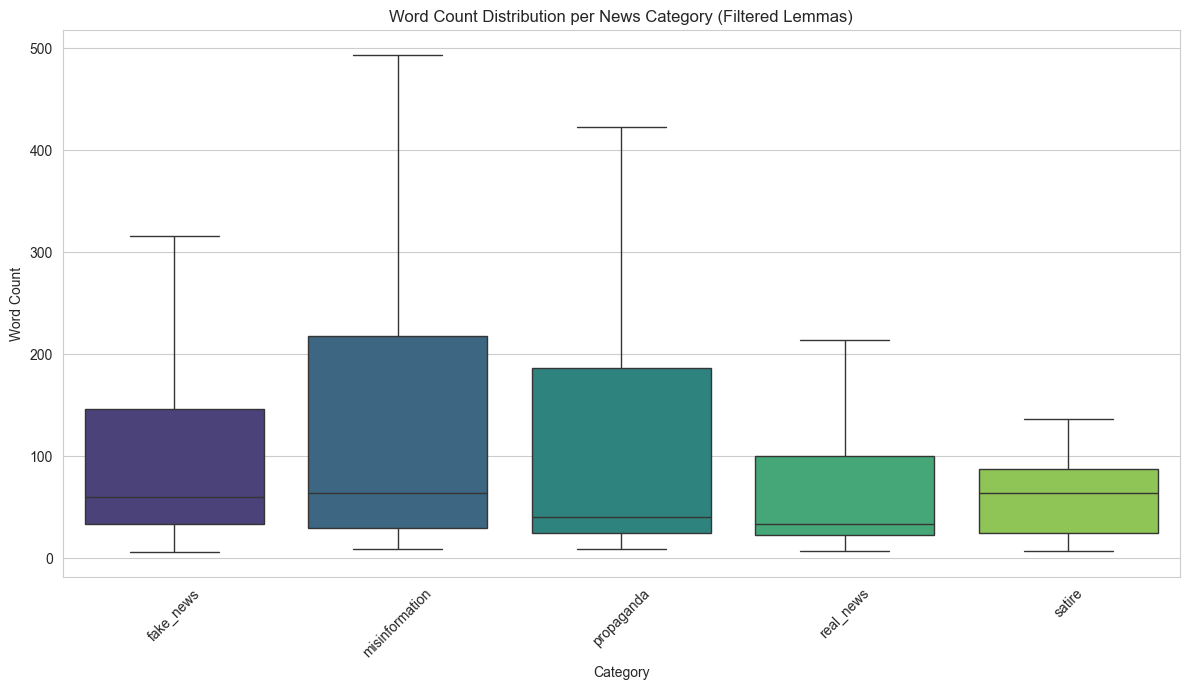

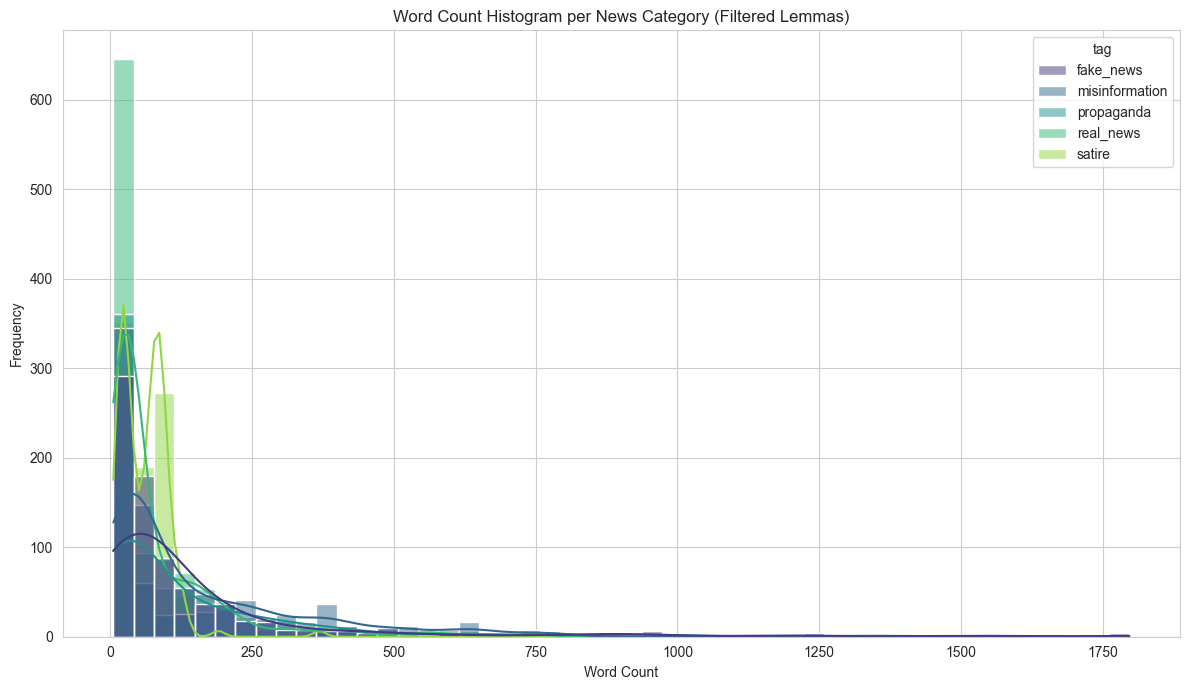

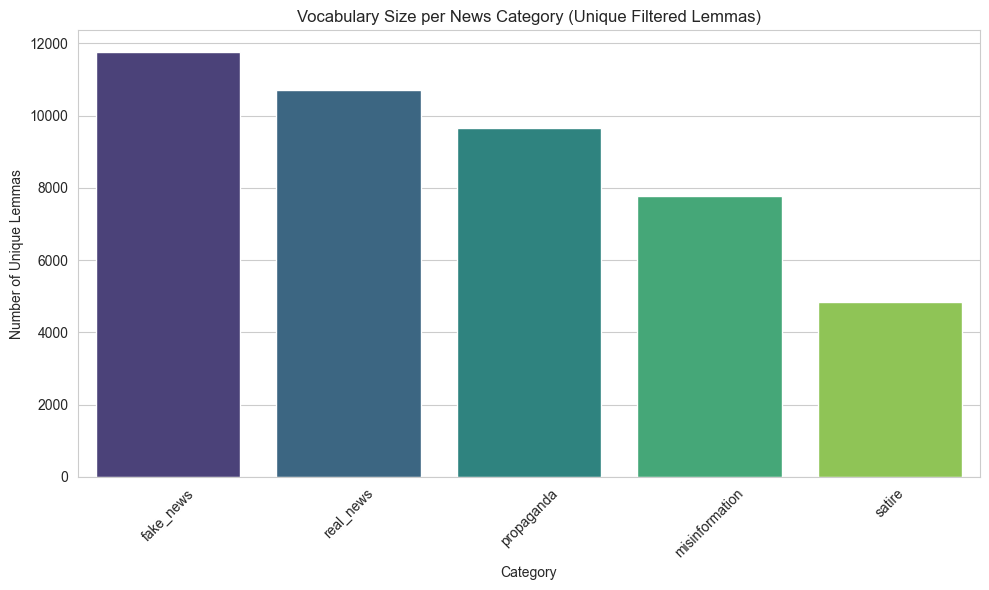

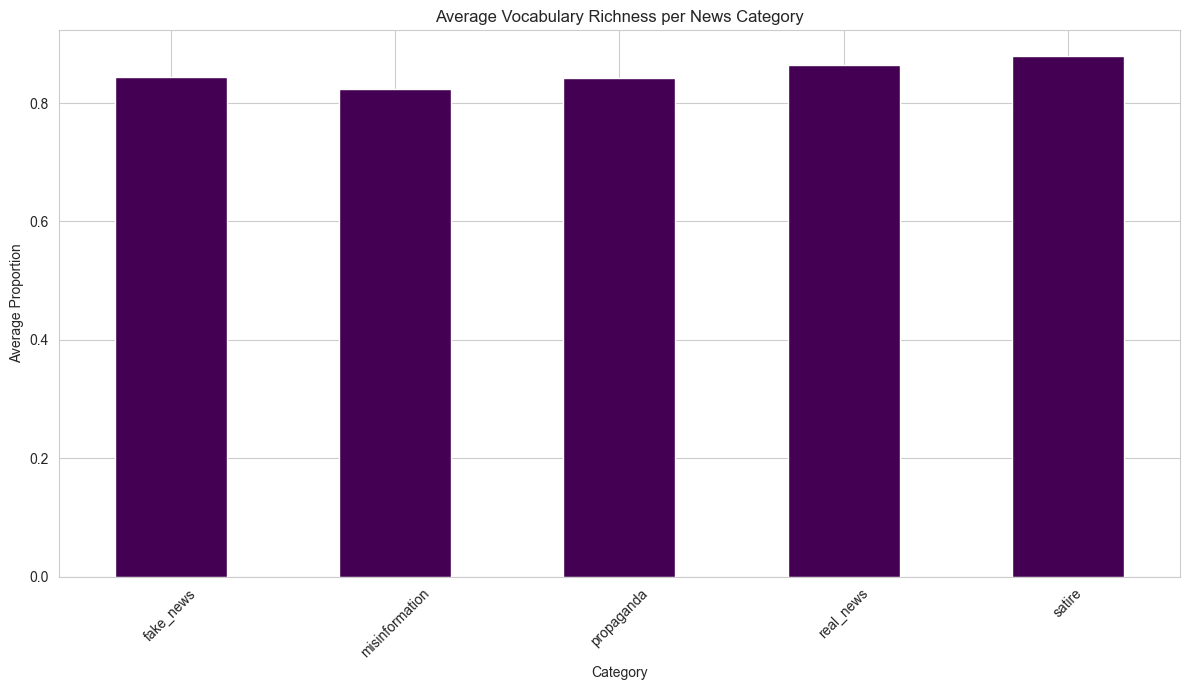

In [7]:
# Word Count Distribution per Category
plt.figure(figsize=(12, 7))
sns.boxplot(data=df_processed, x='tag', y='word_count', palette="viridis", showfliers=False)
plt.title('Word Count Distribution per News Category (Filtered Lemmas)')
plt.xlabel('Category')
plt.ylabel('Word Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(LEXICAL_ANALYSIS_DIR, 'word_count_boxplot.png'))
print(f"\nSaved word count boxplot to {LEXICAL_ANALYSIS_DIR}")

# Word Count Histogram
plt.figure(figsize=(12, 7))
sns.histplot(data=df_processed, x='word_count', hue='tag', kde=True, palette="viridis", bins=50)
plt.title('Word Count Histogram per News Category (Filtered Lemmas)')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
# Limit x-axis if distribution is highly skewed
# plt.xlim(0, word_count_stats['max'].max() / 2)
plt.tight_layout()
plt.savefig(os.path.join(LEXICAL_ANALYSIS_DIR, 'word_count_histogram.png'))
print(f"Saved word count histogram to {LEXICAL_ANALYSIS_DIR}")

# Vocabulary Size per Category
plt.figure(figsize=(10, 6))
sns.barplot(x=vocab_series.index, y=vocab_series.values, palette="viridis")
plt.title('Vocabulary Size per News Category (Unique Filtered Lemmas)')
plt.xlabel('Category')
plt.ylabel('Number of Unique Lemmas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(LEXICAL_ANALYSIS_DIR, 'vocabulary_size_barplot.png'))
print(f"\nSaved vocabulary size barplot to {LEXICAL_ANALYSIS_DIR}")

# POS Proportions Mean
plt.figure(figsize=(12, 7))
vocabulary_richness_stats['mean'].plot(kind='bar', figsize=(12, 7), colormap='viridis')
plt.title('Average Vocabulary Richness per News Category')
plt.xlabel('Category')
plt.ylabel('Average Proportion')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(LEXICAL_ANALYSIS_DIR, 'vocabulary_richness_mean_comparison.png'))
print(f"\nSaved vocabulary richness mean comparison plot to {LEXICAL_ANALYSIS_DIR}")

# Syntactic Analysis

#### POS Analysis

In [13]:
def count_pos_tags(tags_list):
    tag_counts = Counter(tags_list)
    return {
        'noun_count': tag_counts.get('NOUN', 0),
        'verb_count': tag_counts.get('VERB', 0),
        'adj_count': tag_counts.get('ADJ', 0),
        'adv_count': tag_counts.get('ADV', 0)
    }

In [14]:
print("\n--- Syntactic Analysis ---")

pos_counts = df_processed['pos_tags'].apply(lambda x: pd.Series(count_pos_tags(x)))
df_processed = pd.concat([df_processed, pos_counts], axis=1)
print("Added POS count columns (noun_count, verb_count, adj_count, adv_count).")

df_processed['total_tags'] = df_processed['pos_tags'].apply(len)
df_processed['noun_prop'] = df_processed['noun_count'] / df_processed['total_tags'].replace(0, 1)
df_processed['verb_prop'] = df_processed['verb_count'] / df_processed['total_tags'].replace(0, 1)
df_processed['adj_prop'] = df_processed['adj_count'] / df_processed['total_tags'].replace(0, 1)
df_processed['adv_prop'] = df_processed['adv_count'] / df_processed['total_tags'].replace(0, 1)
print("Added POS proportion columns (noun_prop, verb_prop, adj_prop, adv_prop).")

POS_COLUMNS = ['noun_count', 'verb_count', 'adj_count', 'adv_count']

pos_prop_avg = df_processed.groupby('tag')[POS_COLUMNS].mean()
pos_prop_std = df_processed.groupby('tag')[POS_COLUMNS].std()
pos_prop_stats = df_processed.groupby('tag')[POS_COLUMNS].agg(['mean', 'median', 'min', 'max', 'std'])

print("\nAverage POS Counts per Article per Category:")
print(pos_prop_avg)
print("\nStandard Deviation of POS Counts per Article per Category:")
print(pos_prop_std)
print("\nPOS Proportions (mean, median, min, max, std) per Category:")
print(pos_prop_stats)


--- Syntactic Analysis ---
Added POS count columns (noun_count, verb_count, adj_count, adv_count).
Added POS proportion columns (noun_prop, verb_prop, adj_prop, adv_prop).

Average POS Counts per Article per Category:
                noun_count  verb_count  adj_count  adv_count
tag                                                         
fake_news        79.592365   22.237685  25.214286  17.656404
misinformation   79.527293   21.050218  24.490175  16.236900
propaganda       75.191761   21.125000  23.298295  16.285511
real_news        44.948643   10.754845  12.842054   6.500000
satire           30.670115    9.571264   7.679310   9.225287

Standard Deviation of POS Counts per Article per Category:
                noun_count  verb_count  adj_count  adv_count
tag                                                         
fake_news       133.722406   38.510125  45.691599  31.350041
misinformation   92.944124   26.241162  30.333031  23.042218
propaganda      111.138036   32.823703  35.961046 

#### Plot POS


Saved POS proportion comparison plot to C:\Users\Razvan\projects\university\romanian-fake-news-detection\visualizations\dataset_analysis\pos

Saved POS proportion standard deviation comparison plot to C:\Users\Razvan\projects\university\romanian-fake-news-detection\visualizations\dataset_analysis\pos

Saved POS proportion boxplot comparison plot to C:\Users\Razvan\projects\university\romanian-fake-news-detection\visualizations\dataset_analysis\pos


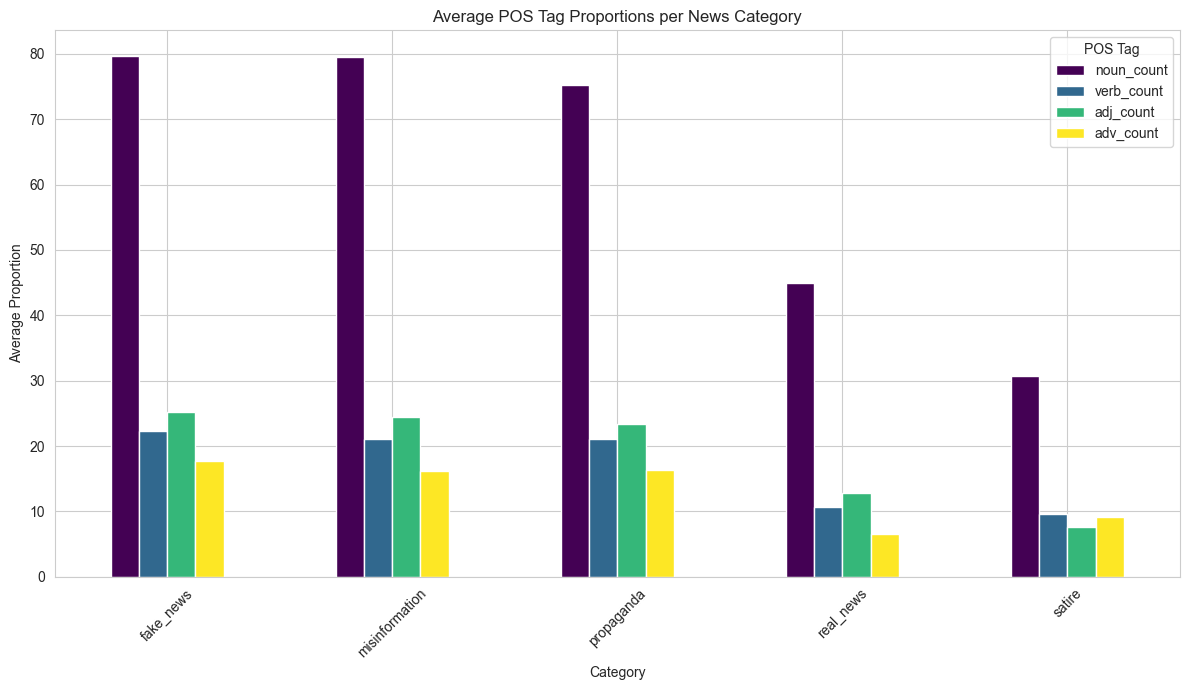

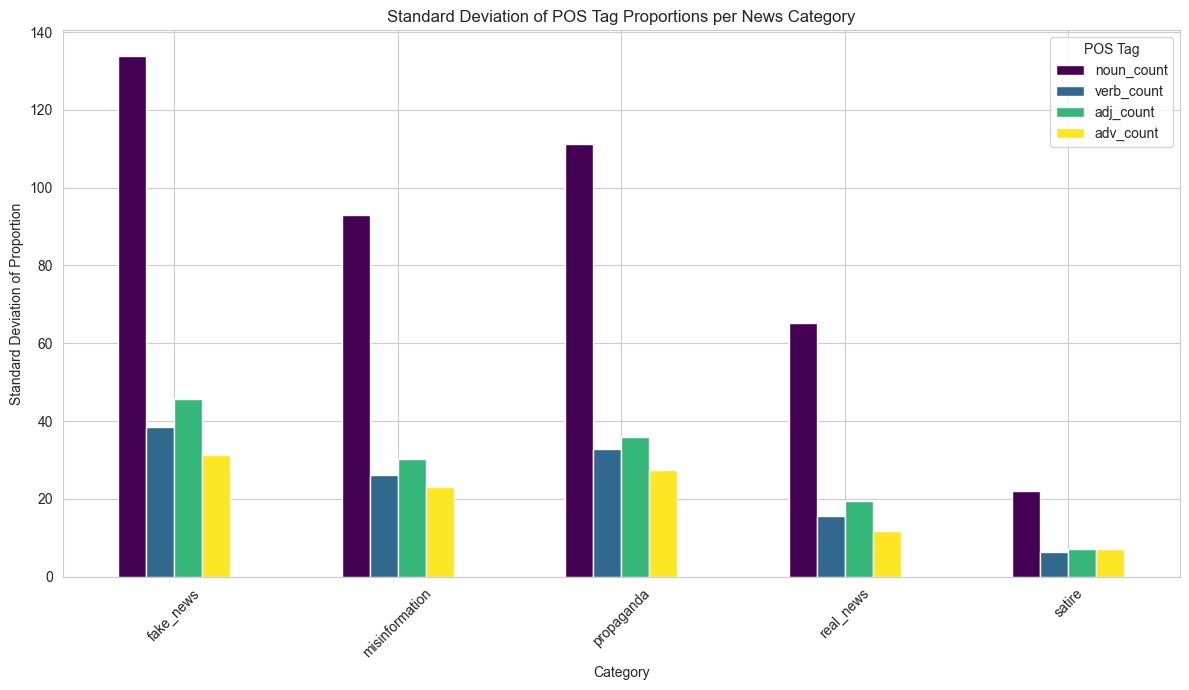

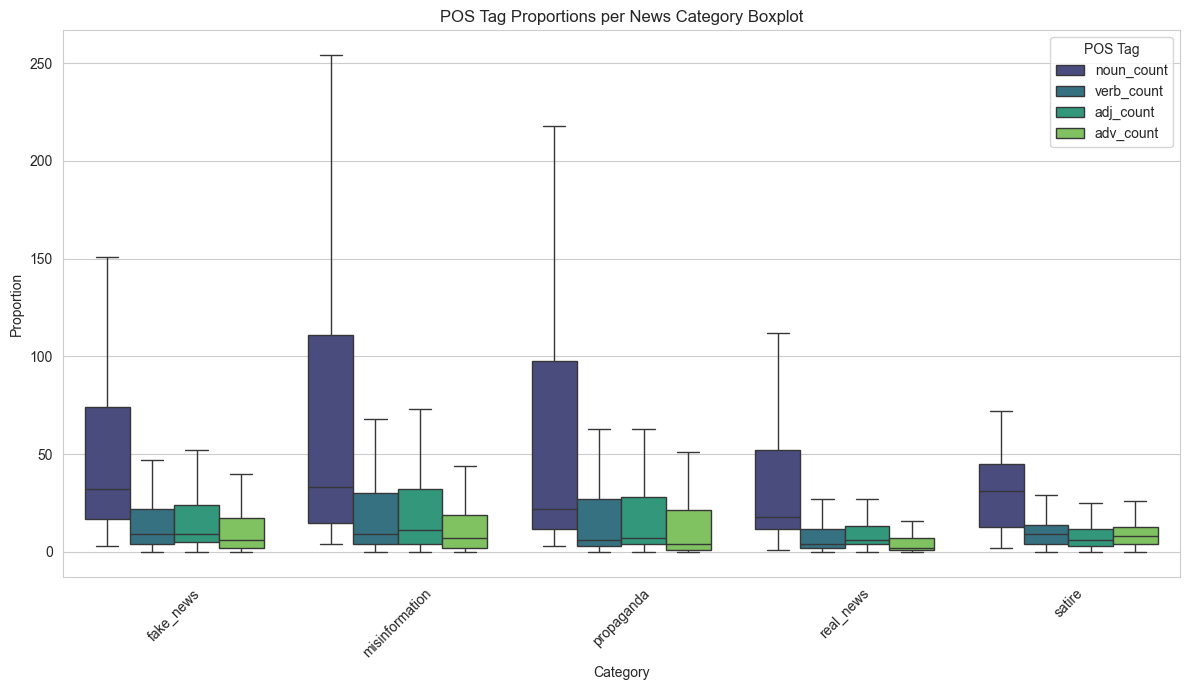

In [10]:
# POS Proportions Mean
pos_prop_avg.plot(kind='bar', figsize=(12, 7), colormap='viridis')
plt.title('Average POS Tag Proportions per News Category')
plt.xlabel('Category')
plt.ylabel('Average Proportion')
plt.xticks(rotation=45)
plt.legend(title='POS Tag')
plt.tight_layout()
plt.savefig(os.path.join(POS_DIR, 'pos_mean_comparison.png'))
print(f"\nSaved POS proportion comparison plot to {POS_DIR}")

# POS Proportions Standard Deviation
pos_prop_std.plot(kind='bar', figsize=(12, 7), colormap='viridis')
plt.title('Standard Deviation of POS Tag Proportions per News Category')
plt.xlabel('Category')
plt.ylabel('Standard Deviation of Proportion')
plt.xticks(rotation=45)
plt.legend(title='POS Tag')
plt.tight_layout()
plt.savefig(os.path.join(POS_DIR, 'pos_std_comparison.png'))
print(f"\nSaved POS proportion standard deviation comparison plot to {POS_DIR}")

# POS Proportions Boxplot
df_melted = df_processed.melt(id_vars=['tag'], value_vars=POS_COLUMNS, var_name='POS_Tag', value_name='Proportion')
plt.figure(figsize=(12, 7))
sns.boxplot(data=df_melted, x='tag', y='Proportion', hue='POS_Tag', palette="viridis", showfliers=False)
plt.title('POS Tag Proportions per News Category Boxplot')
plt.xlabel('Category')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.legend(title='POS Tag')
plt.tight_layout()
plt.savefig(os.path.join(POS_DIR, 'pos_boxplot_comparison.png'))
print(f"\nSaved POS proportion boxplot comparison plot to {POS_DIR}")

# Named Entity Recognition (NER) Analysis

#### NER Analysis

In [15]:
def count_ner_types(entities_list):
    labels = [label for text, label in entities_list]
    ner_counts = Counter(labels)
    return {
        'per_count': ner_counts.get('PERSON', 0),
        'nat_rel_pol_count': ner_counts.get('NAT_REL_POL', 0),
        'org_count': ner_counts.get('ORGANIZATION', 0),
        'fac_count': ner_counts.get('FACILITY', 0),
        'event_count': ner_counts.get('EVENT', 0),
        'money_count': ner_counts.get('MONEY', 0),
        'loc_count': ner_counts.get('LOC', 0)
    }

In [16]:
print("\n--- Named Entity Recognition Analysis ---")

ner_counts = df_processed['entities'].apply(lambda x: pd.Series(count_ner_types(x)))
df_processed = pd.concat([df_processed, ner_counts], axis=1)

df_processed['total_entities'] = df_processed['per_count'] + df_processed['nat_rel_pol_count'] + df_processed['org_count'] + df_processed['fac_count'] + df_processed['event_count'] + df_processed['money_count'] + df_processed['loc_count']
print("Added NER count columns (per_count, nat_rel_pol_count, org_count, fac_count, event_count, money_count, loc_count, total_entities).")

NER_COLUMNS = ['per_count', 'loc_count', 'org_count', 'nat_rel_pol_count', 'fac_count', 'event_count', 'money_count']

ner_mean_stats = df_processed.groupby('tag')[NER_COLUMNS + ['total_entities']].mean()
ner_std_stats = df_processed.groupby('tag')[NER_COLUMNS + ['total_entities']].std()
print("\nAverage NER Counts per Article per Category:")
print(ner_mean_stats)
print("\nStandard Deviation of NER Counts per Article per Category:")
print(ner_std_stats)

df_processed['entity_density'] = df_processed['total_entities'] / df_processed['lemmas'].apply(len).replace(0, 1)
print("Added 'entity_density' column (total entities) / (total lemmas).")

ner_density_stats = df_processed.groupby('tag')['entity_density'].agg(['mean', 'median', 'min', 'max', 'std'])
print("\nEntity Density Statistics per Category:")
print(ner_density_stats)


--- Named Entity Recognition Analysis ---
Added NER count columns (per_count, nat_rel_pol_count, org_count, fac_count, event_count, money_count, loc_count, total_entities).

Average NER Counts per Article per Category:
                per_count  loc_count  org_count  nat_rel_pol_count  fac_count  \
tag                                                                             
fake_news        6.900246   0.261084   2.080049           2.317734   0.820197   
misinformation   6.434498   0.461790   2.053493           3.204148   0.763100   
propaganda       7.792614   0.231534   1.940341           2.161932   0.875000   
real_news        3.812016   0.191860   1.570736           1.488372   0.539729   
satire           3.513793   0.098851   0.573563           0.873563   0.575862   

                event_count  money_count  total_entities  
tag                                                       
fake_news          0.150246     0.131773       12.661330  
misinformation     0.145197     0.3

#### Analyze Top Entities per Category

In [17]:
def get_top_entities(entities_list, entity_type='PERSON', top_n=10):
    entities = [text.lower() for text, label in entities_list if label == entity_type]
    return Counter(entities).most_common(top_n)

In [18]:
for category in df_processed['tag'].unique():
    print(f"\nTop {category.upper()} Persons:")
    all_entities_in_category = df_processed[df_processed['tag'] == category]['entities'].sum()
    top_persons = get_top_entities(all_entities_in_category, entity_type='PERSON', top_n=10)
    print(top_persons if top_persons else "None found")


Top FAKE_NEWS Persons:
[('oameni', 216), ('oamenii', 134), ('persoane', 131), ('președintele', 82), ('el', 80), ('coronavirusului', 79), ('persoanele', 70), ('cetățenilor', 65), ('copiii', 62), ('oamenilor', 57)]

Top MISINFORMATION Persons:
[('oameni', 157), ('persoane', 130), ('cetățenii', 108), ('el', 102), ('coronavirusului', 92), ('președintele', 73), ('oamenii', 66), ('persoanelor', 61), ('cetățenilor', 57), ('copiilor', 56)]

Top PROPAGANDA Persons:
[('oameni', 196), ('persoane', 128), ('el', 108), ('oamenii', 108), ('persoanele', 102), ('coronavirusului', 88), ('morți', 62), ('pacienți', 60), ('medicii', 56), ('președintele', 54)]

Top REAL_NEWS Persons:
[('persoane', 184), ('persoanelor', 51), ('coronavirusului', 51), ('președintele', 49), ('preşedintele', 47), ('persoanele', 46), ('premierul', 45), ('el', 44), ('premierul marcel ciolacu', 38), ('pfizer', 36)]

Top SATIRE Persons:
[('el', 72), ('oamenii', 55), ('vaccinul', 43), ('oameni', 37), ('om', 35), ('specialiștii', 30)

#### Plot NER


Saved Total NER count comparison plot to C:\Users\Razvan\projects\university\romanian-fake-news-detection\visualizations\dataset_analysis\ner

Saved NER count comparison plot to C:\Users\Razvan\projects\university\romanian-fake-news-detection\visualizations\dataset_analysis\ner

Saved NER standard deviation comparison plot to C:\Users\Razvan\projects\university\romanian-fake-news-detection\visualizations\dataset_analysis\ner

Saved POS proportion boxplot comparison plot to C:\Users\Razvan\projects\university\romanian-fake-news-detection\visualizations\dataset_analysis\ner

Saved ner density mean comparison plot to C:\Users\Razvan\projects\university\romanian-fake-news-detection\visualizations\dataset_analysis\ner


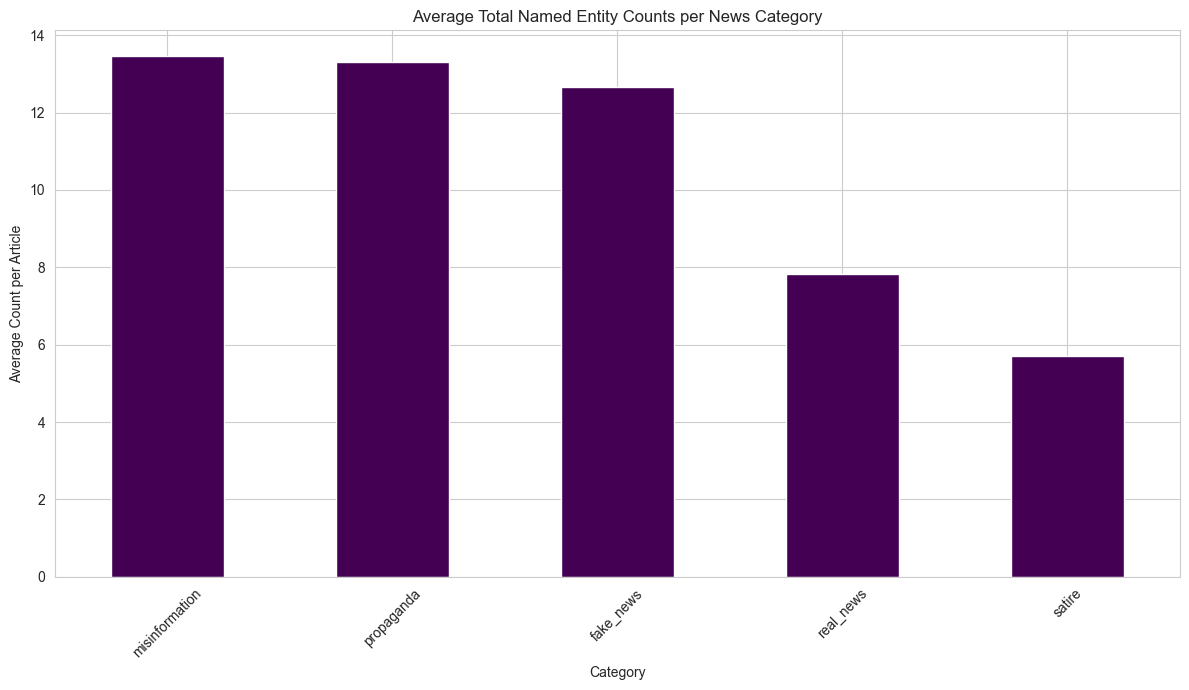

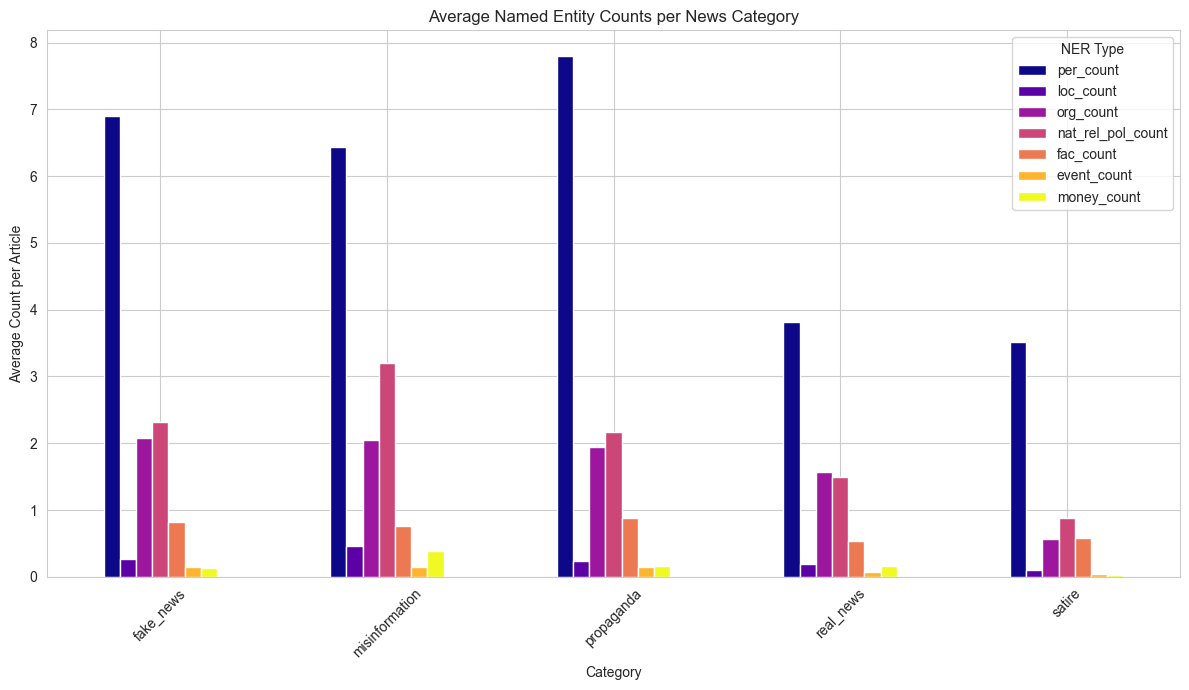

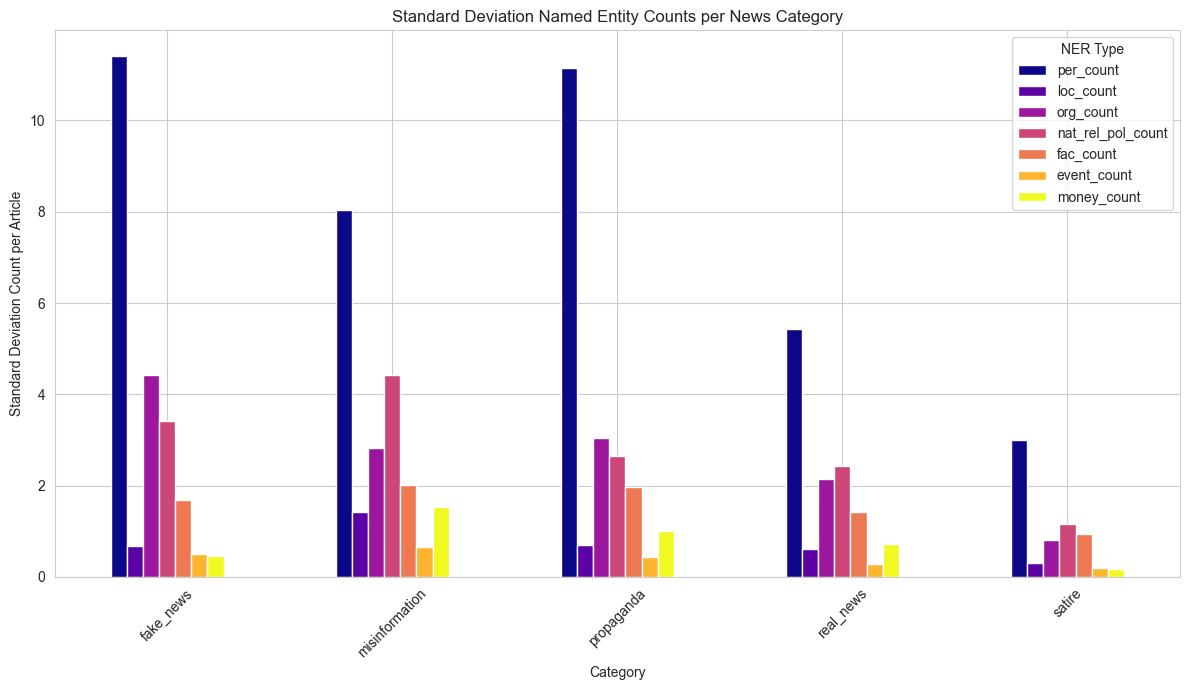

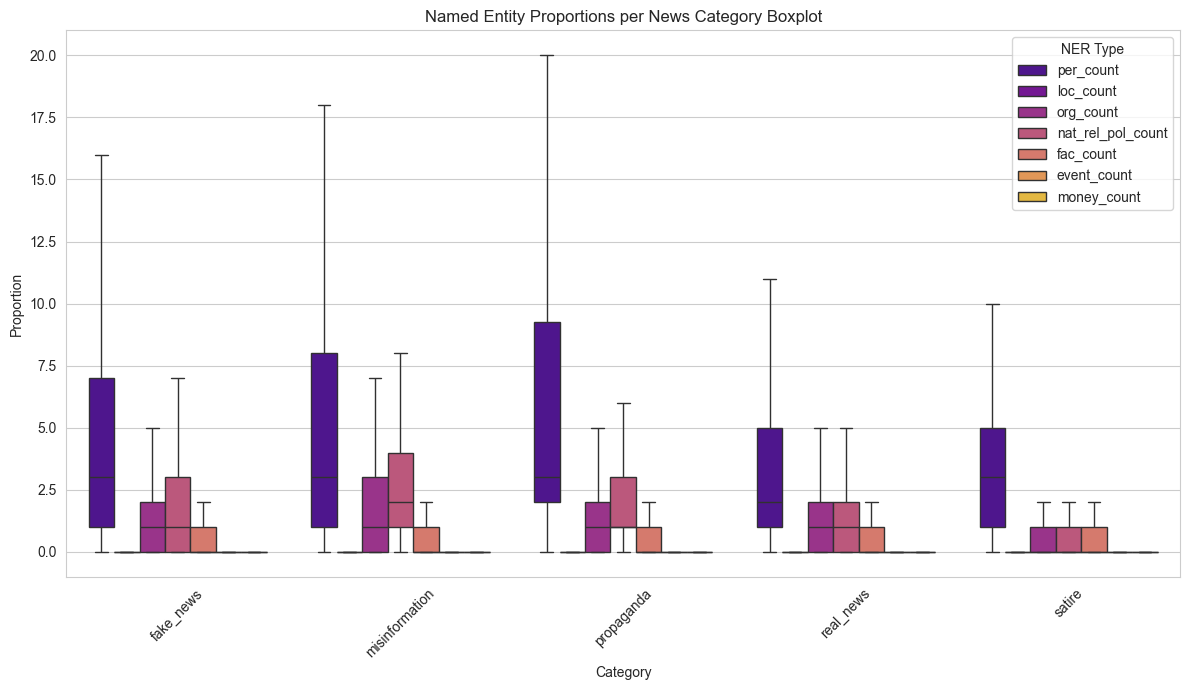

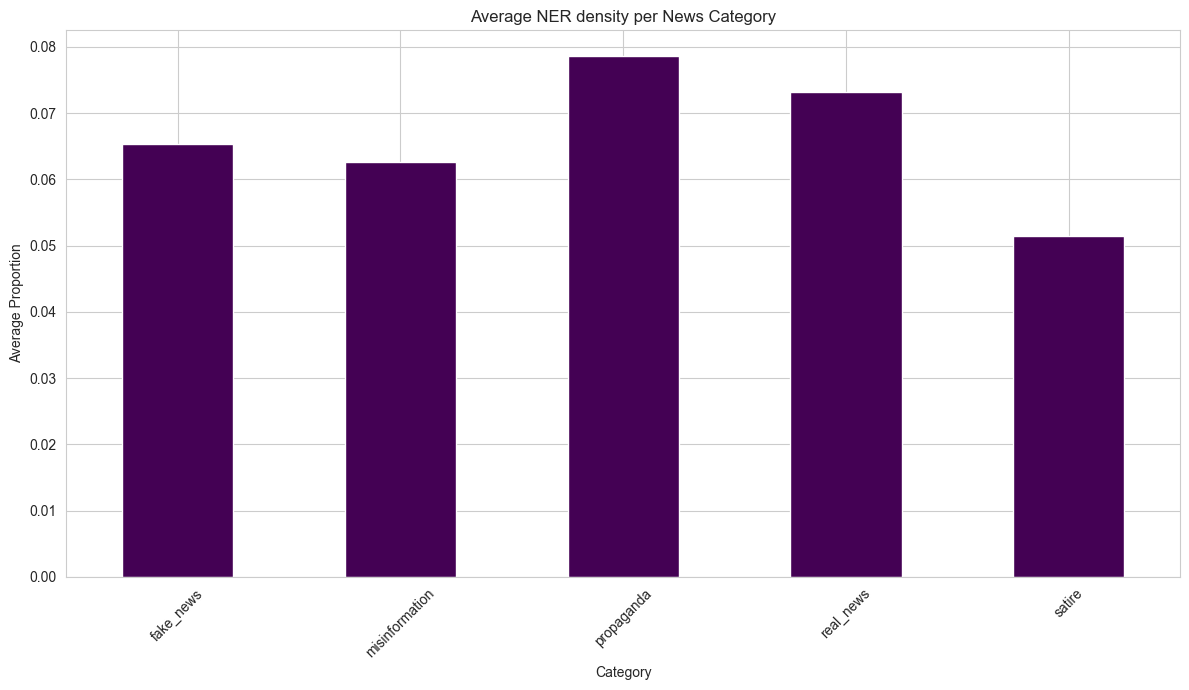

In [15]:
# Average Total NER Counts per News Category
ner_mean_stats['total_entities'].sort_values(ascending=False).plot(kind='bar', figsize=(12, 7), colormap='viridis')
plt.title('Average Total Named Entity Counts per News Category')
plt.xlabel('Category')
plt.ylabel('Average Count per Article')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(NER_DIR, 'total_ner_mean_comparison.png'))
print(f"\nSaved Total NER count comparison plot to {NER_DIR}")

# Average NER Counts
ner_mean_stats[NER_COLUMNS].plot(kind='bar', figsize=(12, 7), colormap='plasma')
plt.title('Average Named Entity Counts per News Category')
plt.xlabel('Category')
plt.ylabel('Average Count per Article')
plt.xticks(rotation=45)
plt.legend(title='NER Type')
plt.tight_layout()
plt.savefig(os.path.join(NER_DIR, 'ner_mean_comparison.png'))
print(f"\nSaved NER count comparison plot to {NER_DIR}")

# NER Counts Standard Deviation
ner_std_stats[NER_COLUMNS].plot(kind='bar', figsize=(12, 7), colormap='plasma')
plt.title('Standard Deviation Named Entity Counts per News Category')
plt.xlabel('Category')
plt.ylabel('Standard Deviation Count per Article')
plt.xticks(rotation=45)
plt.legend(title='NER Type')
plt.tight_layout()
plt.savefig(os.path.join(NER_DIR, 'ner_std_comparison.png'))
print(f"\nSaved NER standard deviation comparison plot to {NER_DIR}")

# NER Counts Boxplot
df_melted = df_processed.melt(id_vars=['tag'], value_vars=NER_COLUMNS, var_name='NER_Type', value_name='Proportion')
plt.figure(figsize=(12, 7))
sns.boxplot(data=df_melted, x='tag', y='Proportion', hue='NER_Type', palette="plasma", showfliers=False)
plt.title('Named Entity Proportions per News Category Boxplot')
plt.xlabel('Category')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.legend(title='NER Type')
plt.tight_layout()
plt.savefig(os.path.join(NER_DIR, 'ner_boxplot_comparison.png'))
print(f"\nSaved POS proportion boxplot comparison plot to {NER_DIR}")

# POS Proportions Mean
plt.figure(figsize=(12, 7))
ner_density_stats['mean'].plot(kind='bar', figsize=(12, 7), colormap='viridis')
plt.title('Average NER density per News Category')
plt.xlabel('Category')
plt.ylabel('Average Proportion')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(NER_DIR, 'ner_density_mean_comparison.png'))
print(f"\nSaved ner density mean comparison plot to {NER_DIR}")

# Emotion & Sentiment Analysis

#### Load RoEmoLex Lexicon

In [19]:
encodings_to_try = ['utf-8', 'latin1', 'iso-8859-2']
df_roemo_words = None

for encoding in encodings_to_try:
    try:
        df_roemo_words = pd.read_csv(ROEMOLEX_WORDS_PATH, encoding=encoding, delimiter=';')
        print(f"Successfully loaded RoEmoLex words with encoding: {encoding}")
        break
    except FileNotFoundError:
        print(f"Error: RoEmoLex words file not found at {ROEMOLEX_WORDS_PATH}")
        break
    except UnicodeDecodeError:
        print(f"Failed to load RoEmoLex words with encoding: {encoding}")
    except Exception as e:
        print(f"An unexpected error occurred loading RoEmoLex words: {e}")
        break

Successfully loaded RoEmoLex words with encoding: utf-8


In [20]:
if df_roemo_words is not None:
    print("\nRoEmoLex Words Lexicon Info:")
    print(f"Shape: {df_roemo_words.shape}")
    print("Columns:", df_roemo_words.columns.tolist())
    print("\nFirst 5 rows:\n", df_roemo_words.head())
    print("\nData types:\n", df_roemo_words.dtypes)

    LEMMA_COL = 'word'
    EMOTION_COLS = ['Anger', 'Anticipation', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust']
    POLARITY_COLS = ['Positivity', 'Negativity']
    ALL_SCORE_COLS = EMOTION_COLS + POLARITY_COLS

    missing_cols = [col for col in [LEMMA_COL] + ALL_SCORE_COLS if col not in df_roemo_words.columns]
    if missing_cols:
        print(f"\nERROR: Expected columns missing in RoEmoLex words file: {missing_cols}")
        print(f"Available columns: {df_roemo_words.columns.tolist()}")
        df_roemo_words = None
    else:
         print("\nAll expected lexicon columns found.")
         for col in ALL_SCORE_COLS:
              df_roemo_words[col] = pd.to_numeric(df_roemo_words[col], errors='coerce')
         df_roemo_words[ALL_SCORE_COLS] = df_roemo_words[ALL_SCORE_COLS].fillna(0).astype(int)
         print("Score columns converted to numeric.")


RoEmoLex Words Lexicon Info:
Shape: (8486, 14)
Columns: ['Unnamed: 0', 'word', 'part_of_speech', 'Positivity', 'Negativity', 'Anger', 'Anticipation', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust', 'wn_synset_id']

First 5 rows:
    Unnamed: 0         word part_of_speech  Positivity  Negativity  Anger  \
0           0      se izbi           Verb           0           1      0   
1           1         bate           Verb           0           1      1   
2           3         abac           Noun           0           0      0   
3           4  numărătoare           Noun           0           0      0   
4           5      abandon           Noun           0           1      0   

   Anticipation  Disgust  Fear  Joy  Sadness  Surprise  Trust  \
0             0        0     1    0        1         1      0   
1             0        0     1    0        0         0      0   
2             0        0     0    0        0         0      1   
3             0        0     0    0       

#### Create Lookup Dictionary

In [22]:
roemo_dict = {}
if df_roemo_words is not None:
    df_roemo_words[LEMMA_COL] = df_roemo_words[LEMMA_COL].str.lower()

    df_roemo_unique = df_roemo_words.drop_duplicates(subset=[LEMMA_COL], keep='first')
    print(f"Dropped {len(df_roemo_words) - len(df_roemo_unique)} duplicate lemmas, keeping first entry.")

    for index, row in df_roemo_unique.iterrows():
        lemma = row[LEMMA_COL]
        scores = row[ALL_SCORE_COLS].to_dict()
        roemo_dict[lemma] = scores

    print(f"RoEmoLex dictionary created with {len(roemo_dict)} unique lemmas.")
    
    sample_lemma = list(roemo_dict.keys())[0]
    print(f"Sample entry for '{sample_lemma}': {roemo_dict[sample_lemma]}")
else:
    print("\nSkipping RoEmoLex dictionary creation because the lexicon file failed to load or columns were missing.")

Dropped 2156 duplicate lemmas, keeping first entry.
RoEmoLex dictionary created with 6330 unique lemmas.
Sample entry for 'se izbi': {'Anger': 0, 'Anticipation': 0, 'Disgust': 0, 'Fear': 1, 'Joy': 0, 'Sadness': 1, 'Surprise': 1, 'Trust': 0, 'Positivity': 0, 'Negativity': 1}


In [27]:
NEW_COUNT_COL = 'matched_emotion_words'
ALL_ANALYSIS_COLS = ALL_SCORE_COLS + [NEW_COUNT_COL]

#### Emotion Scoring

In [28]:
def calculate_emotion_scores(lemma_list, lexicon_dict):
    doc_scores = {col: 0 for col in ALL_SCORE_COLS}
    matched_words = 0
    if not isinstance(lemma_list, list):
        doc_scores[NEW_COUNT_COL] = matched_words 
        return doc_scores

    for lemma in lemma_list:
        lemma_lower = lemma.lower()
        if lemma_lower in lexicon_dict:
            matched_words += 1
            lemma_scores = lexicon_dict[lemma_lower]
            for emotion_or_polarity, score in lemma_scores.items():
                doc_scores[emotion_or_polarity] += score

    doc_scores[NEW_COUNT_COL] = matched_words
    return doc_scores

In [29]:
if roemo_dict:
    print("\n--- Applying Emotion Scoring to DataFrame ---")
    print("Calculating scores and matched word count for each document...")
    start_time = time.time()

    analysis_scores_list = df_processed['lemmas'].apply(lambda x: calculate_emotion_scores(x, roemo_dict))

    analysis_scores_df = pd.json_normalize(analysis_scores_list)
    analysis_scores_df.index = df_processed.index # Align index

    cols_to_drop = [col for col in analysis_scores_df.columns if col in df_processed.columns]
    if cols_to_drop:
         print(f"Dropping existing score columns: {cols_to_drop}")
         df_processed = df_processed.drop(columns=cols_to_drop)
        
    df_processed = pd.concat([df_processed, analysis_scores_df], axis=1)

    end_time = time.time()
    print(f"Emotion scoring finished in {end_time - start_time:.2f} seconds.")
    print("Added emotion and polarity scores and matched emotion words columns to DataFrame.")
    print("Columns added:", analysis_scores_df.columns.tolist())

    emotion_analysis_avg = df_processed.groupby('tag')[ALL_ANALYSIS_COLS].mean()
    emotion_analysis_std = df_processed.groupby('tag')[ALL_ANALYSIS_COLS].std()
    emotion_analysis_stats = df_processed.groupby('tag')[ALL_ANALYSIS_COLS].agg(['mean', 'median', 'min', 'max', 'std'])
    print("\nMean Emotion/Polarity Scores & Emotional Word Count per Category:")
    print(emotion_analysis_avg)
    print("\nStandard Deviation of Emotion/Polarity Scores & Emotional Word Count per Category:")
    print(emotion_analysis_std)
    print("\nEmotion/Polarity Scores & Emotional Word Count Stats (mean, median, min, max, std) per Category:")
    print(emotion_analysis_stats)
    
    df_processed['anger_mean'] = df_processed['Anger'] / df_processed[NEW_COUNT_COL].replace(0, 1)
    df_processed['joy_mean'] = df_processed['Joy'] / df_processed[NEW_COUNT_COL].replace(0, 1)
    df_processed['sadness_mean'] = df_processed['Sadness'] / df_processed[NEW_COUNT_COL].replace(0, 1)
    df_processed['trust_mean'] = df_processed['Trust'] / df_processed[NEW_COUNT_COL].replace(0, 1)
    df_processed['anticipation_mean'] = df_processed['Anticipation'] / df_processed[NEW_COUNT_COL].replace(0, 1)
    df_processed['disgust_mean'] = df_processed['Disgust'] / df_processed[NEW_COUNT_COL].replace(0, 1)
    df_processed['fear_mean'] = df_processed['Fear'] / df_processed[NEW_COUNT_COL].replace(0, 1)
    df_processed['surprise_mean'] = df_processed['Surprise'] / df_processed[NEW_COUNT_COL].replace(0, 1)
    
    MEAN_SCORE_COLS = [
        'anger_mean', 'joy_mean', 'sadness_mean', 'trust_mean',
        'anticipation_mean', 'disgust_mean', 'fear_mean', 'surprise_mean'
    ]

    emotion_analysis_stats_per_article = df_processed.groupby('tag')[MEAN_SCORE_COLS].mean()
    print("\nMean Emotion Scores per Category (normalized by matched words):")
    print(emotion_analysis_stats_per_article[MEAN_SCORE_COLS])
else:
    print("\nSkipping emotion scoring and analysis because RoEmoLex dictionary was not created.")


--- Applying Emotion Scoring to DataFrame ---
Calculating scores and matched word count for each document...
Emotion scoring finished in 0.95 seconds.
Added emotion and polarity scores and matched emotion words columns to DataFrame.
Columns added: ['Anger', 'Anticipation', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust', 'Positivity', 'Negativity', 'matched_emotion_words']

Mean Emotion/Polarity Scores & Emotional Word Count per Category:
                   Anger  Anticipation   Disgust       Fear       Joy  \
tag                                                                     
fake_news       6.850985     11.860837  4.035714  10.389163  4.564039   
misinformation  5.271834     11.994541  2.663755   7.694323  4.828603   
propaganda      6.125000     11.028409  3.738636  10.579545  4.133523   
real_news       2.072674      6.100775  0.990310   3.690891  2.245155   
satire          2.663218      4.677011  1.819540   3.596552  2.272414   

                 Sadness  Surprise 

#### Plot Emotion Distribution


Saved emotion mean comparison plot to C:\Users\Razvan\projects\university\romanian-fake-news-detection\visualizations\dataset_analysis\emotion_analysis

Saved mean emotion scores bar chart to C:\Users\Razvan\projects\university\romanian-fake-news-detection\visualizations\dataset_analysis\emotion_analysis

Saved mean emotion scores bar chart to C:\Users\Razvan\projects\university\romanian-fake-news-detection\visualizations\dataset_analysis\emotion_analysis

Saved mean emotion scores bar chart to C:\Users\Razvan\projects\university\romanian-fake-news-detection\visualizations\dataset_analysis\emotion_analysis

Saved mean emotion scores bar chart to C:\Users\Razvan\projects\university\romanian-fake-news-detection\visualizations\dataset_analysis\emotion_analysis

Saved emotion scores boxplot to C:\Users\Razvan\projects\university\romanian-fake-news-detection\visualizations\dataset_analysis\emotion_analysis
Saved mean matched words bar chart to C:\Users\Razvan\projects\university\romanian-f

<Figure size 1200x700 with 0 Axes>

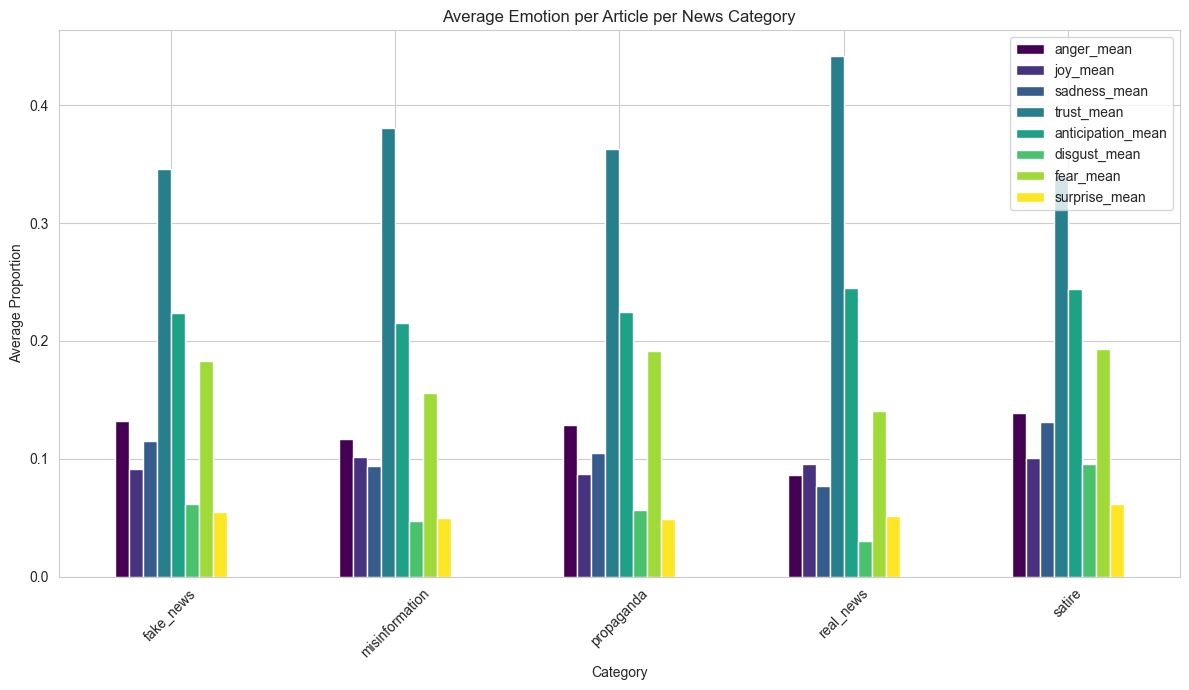

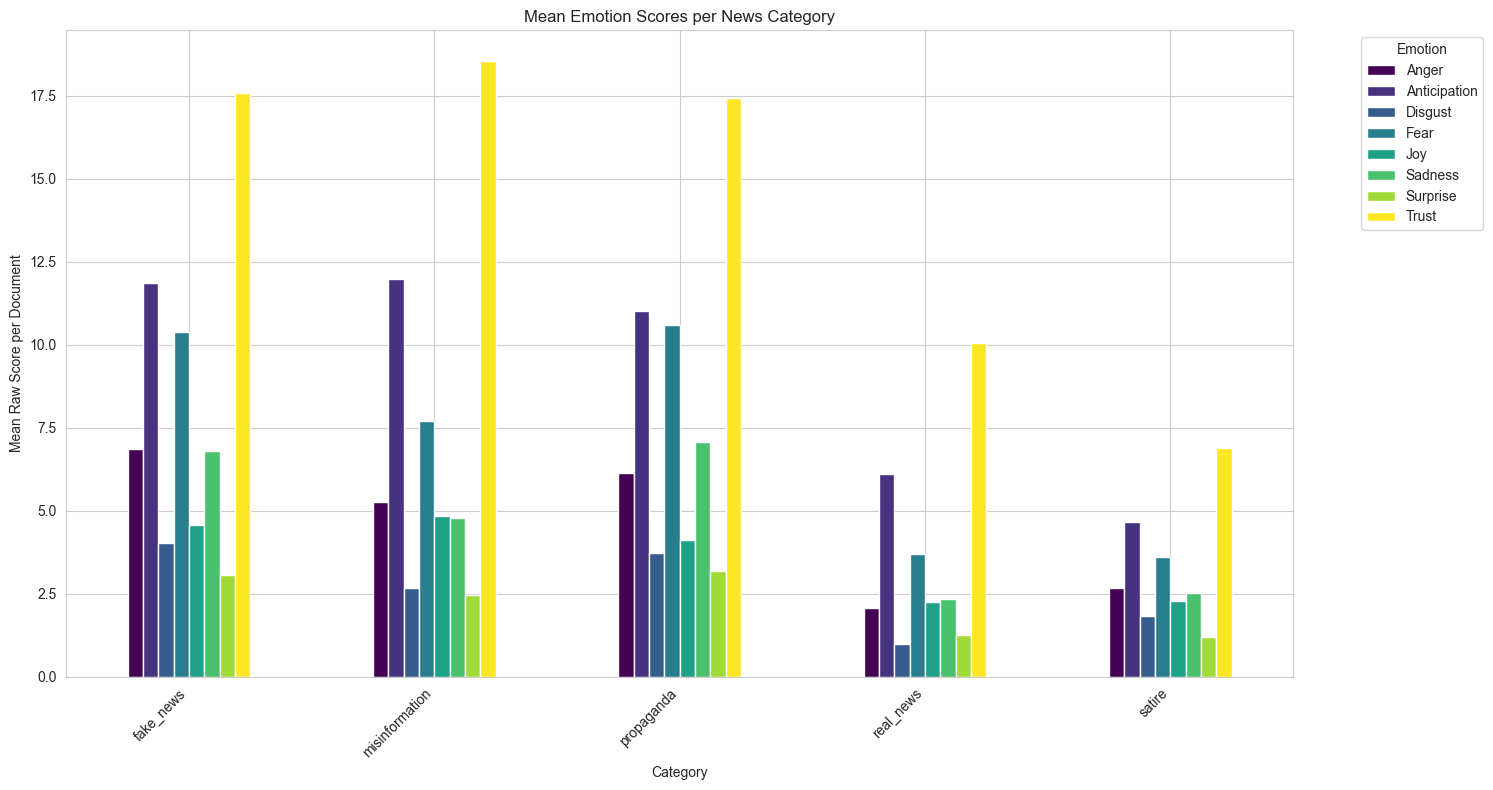

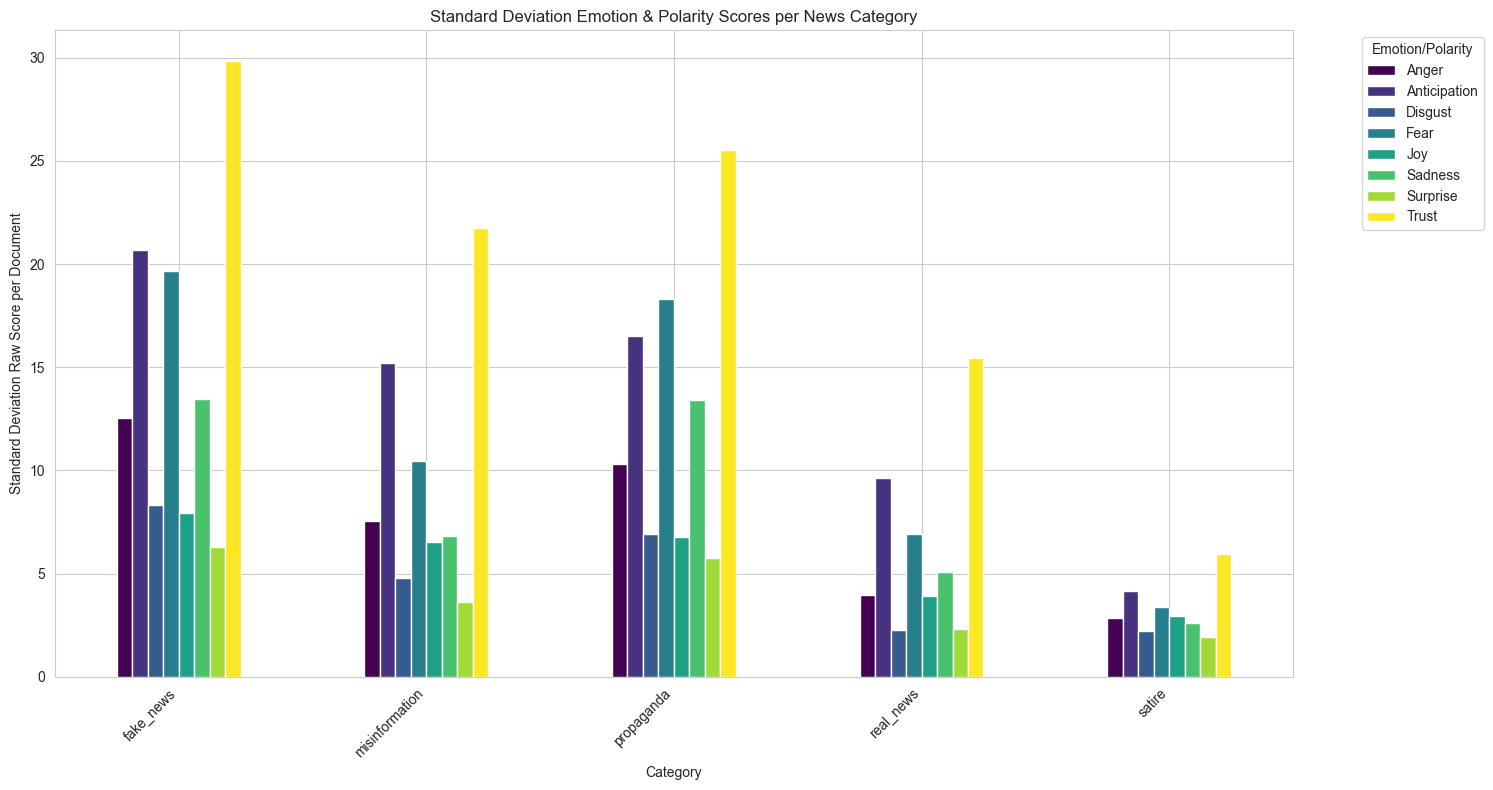

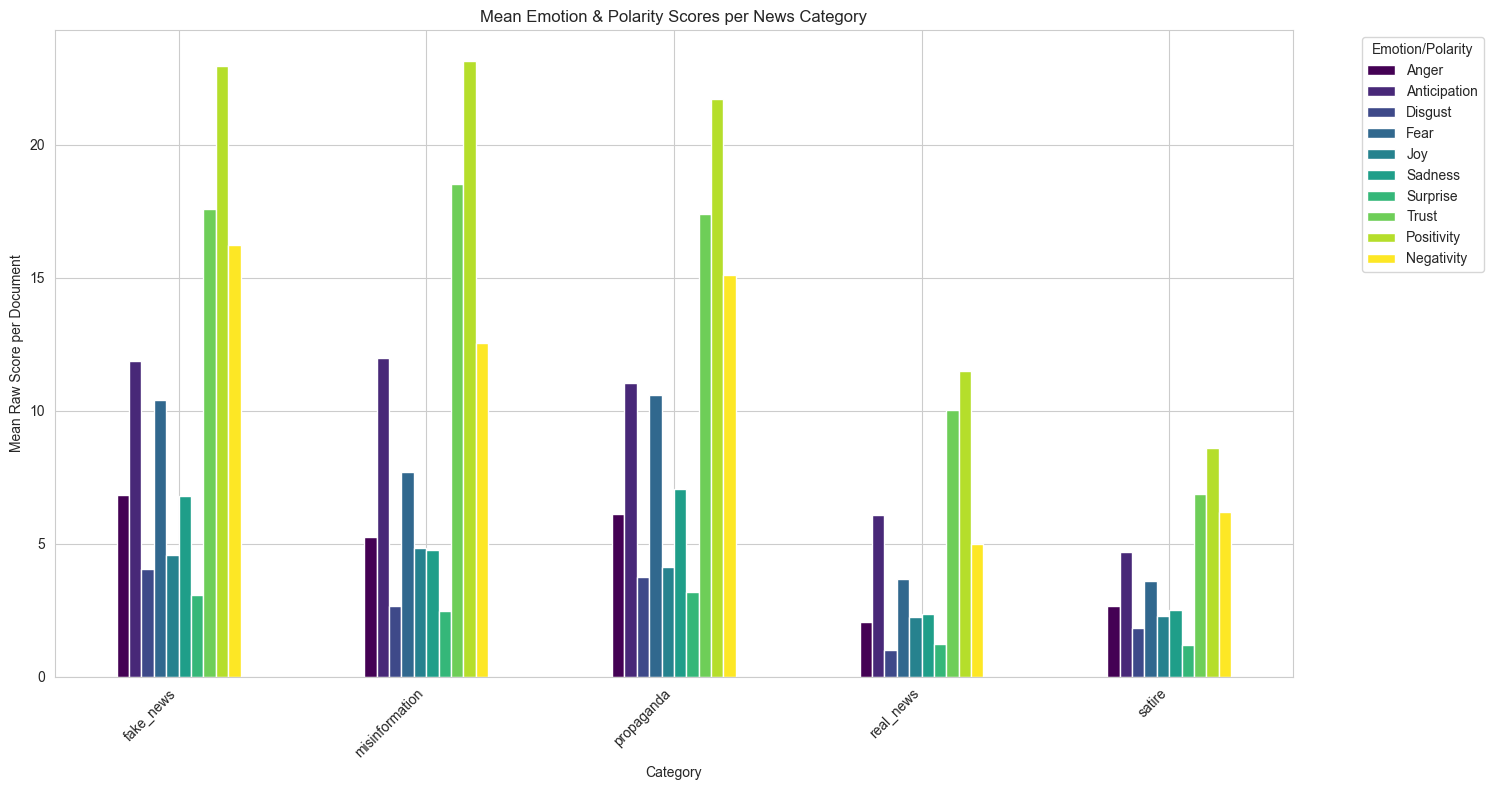

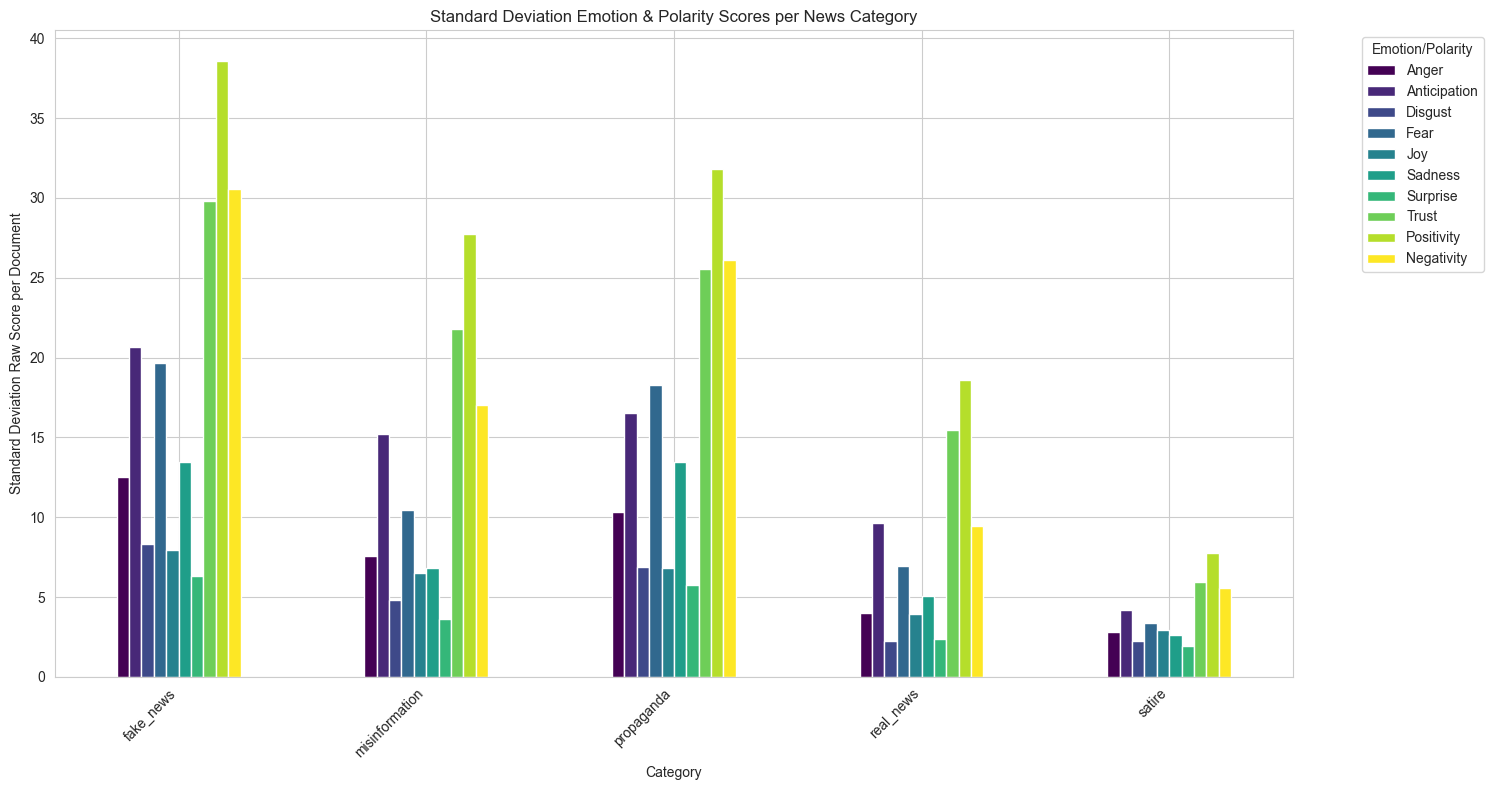

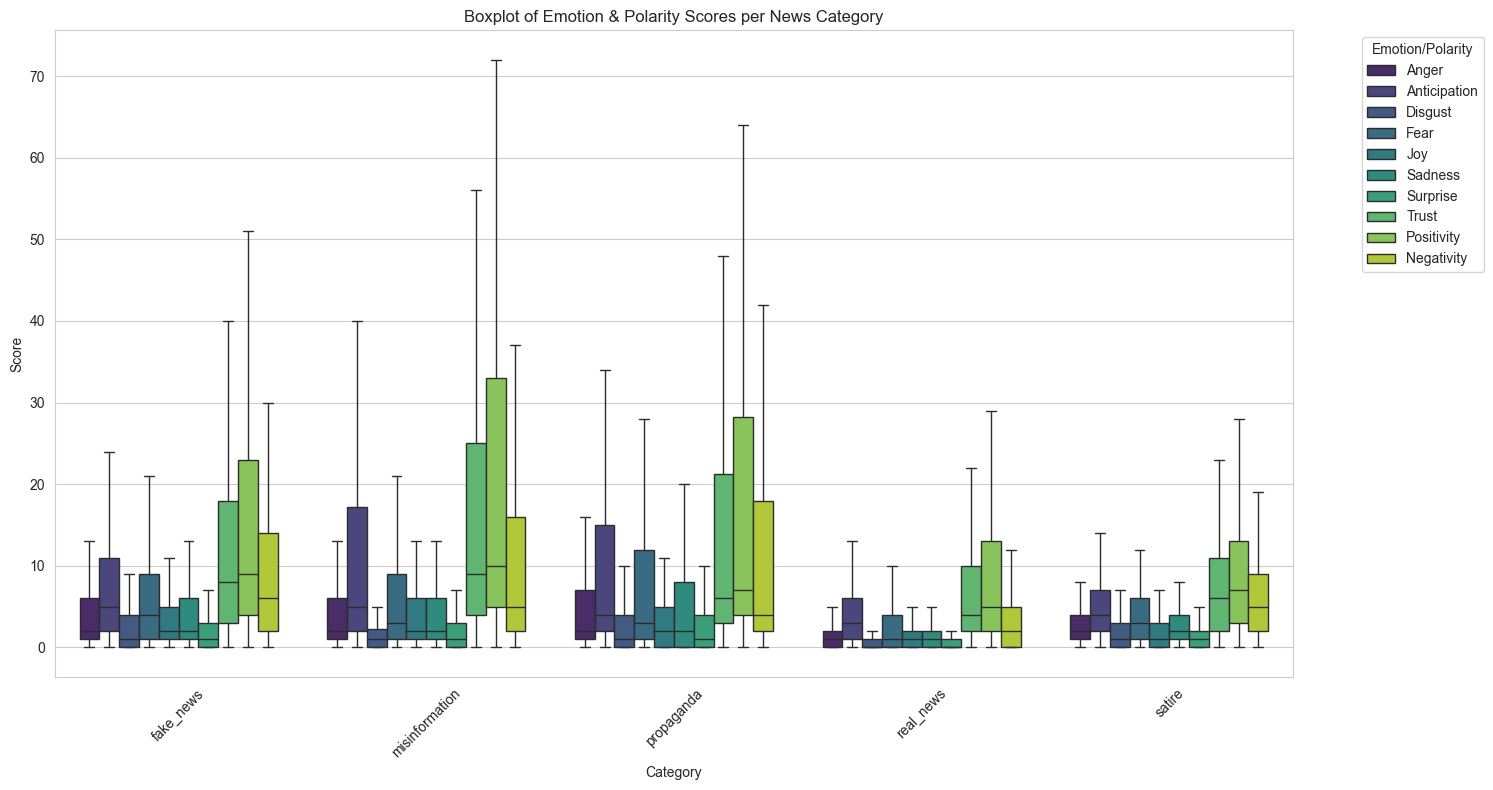

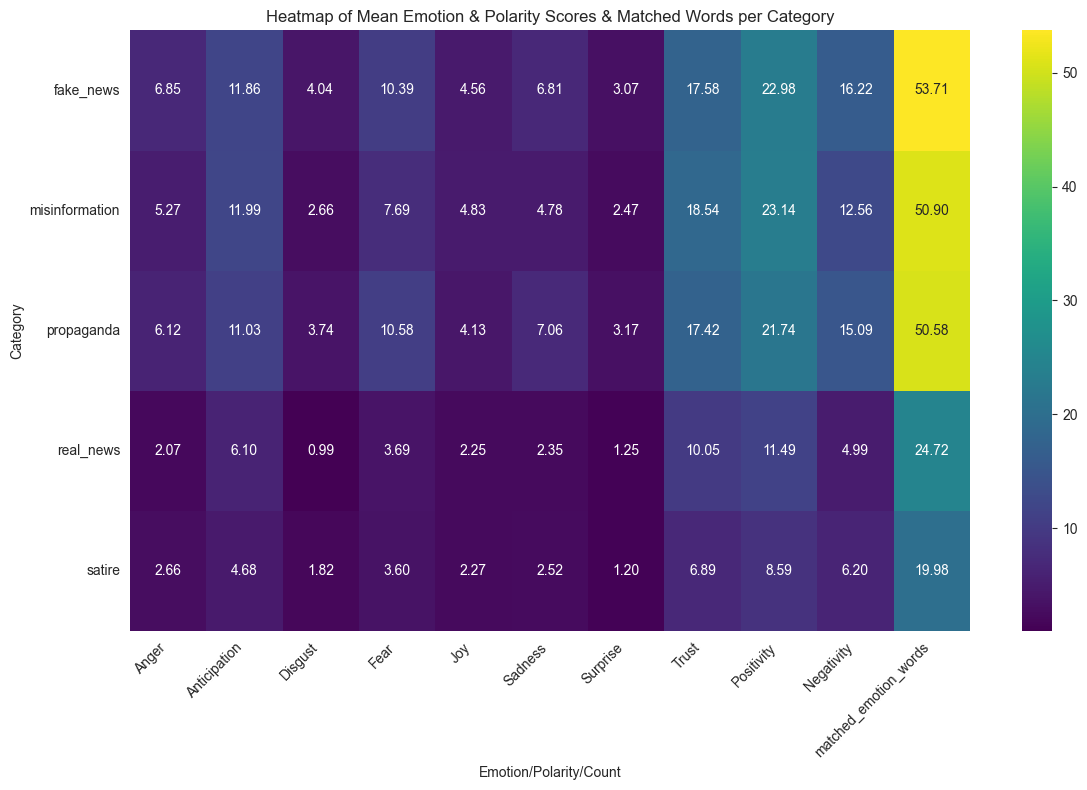

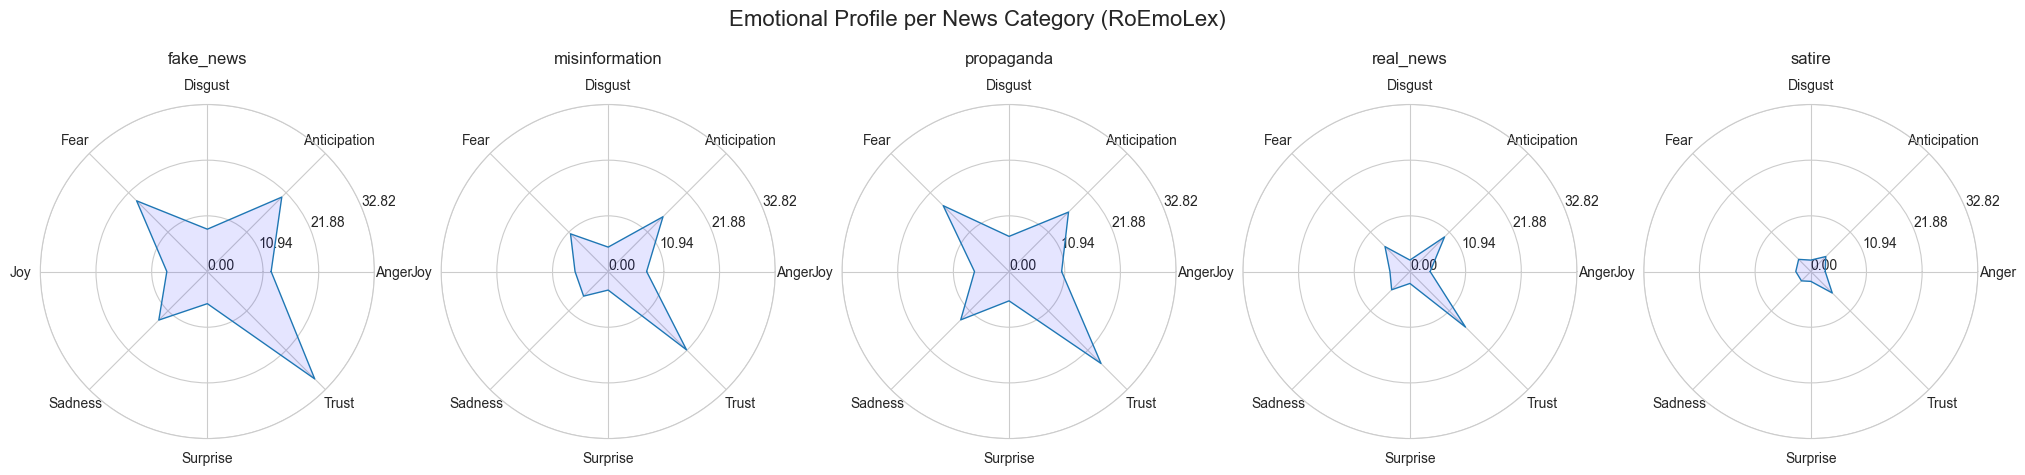

In [30]:
# Bar Chart of Mean Scores Per Article Per Category
plt.figure(figsize=(12, 7))
emotion_analysis_stats_per_article[MEAN_SCORE_COLS].plot(kind='bar', figsize=(12, 7), colormap='viridis')
plt.title('Average Emotion per Article per News Category')
plt.xlabel('Category')
plt.ylabel('Average Proportion')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(EMOTION_DIR, 'emotion_mean_per_article_per_category_comparison.png'))
print(f"\nSaved emotion mean comparison plot to {EMOTION_DIR}")

# Bar Chart of Mean Scores (Emotions & Polarity only)
emotion_analysis_avg[EMOTION_COLS].plot(kind='bar', figsize=(15, 8), colormap='viridis')
plt.title('Mean Emotion Scores per News Category')
plt.xlabel('Category')
plt.ylabel('Mean Raw Score per Document')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Emotion', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(EMOTION_DIR, 'emotion_scores_mean_bar.png'))
print(f"\nSaved mean emotion scores bar chart to {EMOTION_DIR}")

# Bar Chart of Standard Deviation of Scores
emotion_analysis_std[EMOTION_COLS].plot(kind='bar', figsize=(15, 8), colormap='viridis')
plt.title('Standard Deviation Emotion & Polarity Scores per News Category')
plt.xlabel('Category')
plt.ylabel('Standard Deviation Raw Score per Document')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Emotion/Polarity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(EMOTION_DIR, 'emotion_scores_std_bar.png'))
print(f"\nSaved mean emotion scores bar chart to {EMOTION_DIR}")

# Bar Chart of Mean Scores (Emotions & Polarity only)
emotion_analysis_avg[ALL_SCORE_COLS].plot(kind='bar', figsize=(15, 8), colormap='viridis')
plt.title('Mean Emotion & Polarity Scores per News Category')
plt.xlabel('Category')
plt.ylabel('Mean Raw Score per Document')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Emotion/Polarity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(EMOTION_DIR, 'emotion_polarity_scores_mean_bar.png'))
print(f"\nSaved mean emotion scores bar chart to {EMOTION_DIR}")

# Bar Chart of Standard Deviation of Scores
emotion_analysis_std[ALL_SCORE_COLS].plot(kind='bar', figsize=(15, 8), colormap='viridis')
plt.title('Standard Deviation Emotion & Polarity Scores per News Category')
plt.xlabel('Category')
plt.ylabel('Standard Deviation Raw Score per Document')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Emotion/Polarity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(EMOTION_DIR, 'emotion_polarity_scores_std_bar.png'))
print(f"\nSaved mean emotion scores bar chart to {EMOTION_DIR}")

# Boxplot of Emotion Scores
df_melted = df_processed.melt(id_vars=['tag'], value_vars=ALL_SCORE_COLS, var_name='Emotion/Polarity', value_name='Score')
plt.figure(figsize=(15, 8))
sns.boxplot(data=df_melted, x='tag', y='Score', hue='Emotion/Polarity', palette="viridis", showfliers=False)
plt.title('Boxplot of Emotion & Polarity Scores per News Category')
plt.xlabel('Category')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(title='Emotion/Polarity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(EMOTION_DIR, 'emotion_scores_boxplot.png'))
print(f"\nSaved emotion scores boxplot to {EMOTION_DIR}")

# Bar Chart of Mean Matched Emotion Words
plt.figure(figsize=(10, 6))
emotion_analysis_avg[NEW_COUNT_COL].plot(kind='bar', color='skyblue')
plt.title(f'Mean Number of Matched Emotion Words ({NEW_COUNT_COL}) per Category')
plt.xlabel('Category')
plt.ylabel('Average Count per Document')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(EMOTION_DIR, 'matched_words_mean_bar.png'))
print(f"Saved mean matched words bar chart to {EMOTION_DIR}")
plt.close()

# Heatmap of Mean Scores (Including matched words count)
plt.figure(figsize=(12, 8))
sns.heatmap(emotion_analysis_avg, annot=True, cmap="viridis", fmt=".2f")
plt.title('Heatmap of Mean Emotion & Polarity Scores & Matched Words per Category')
plt.xlabel('Emotion/Polarity/Count')
plt.ylabel('Category')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(EMOTION_DIR, 'emotion_scores_mean_heatmap.png'))
print(f"\nSaved mean emotion scores heatmap to {EMOTION_DIR}")


categories = emotion_analysis_std.index.tolist()
emotion_labels = ['Anger', 'Anticipation', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust']
num_vars = len(emotion_labels)

angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]

fig, axs = plt.subplots(nrows=1, ncols=len(categories), figsize=(5 * len(categories), 5),
                     subplot_kw=dict(polar=True))
fig.suptitle('Emotional Profile per News Category (RoEmoLex)', fontsize=16, y=1.02)

if len(categories) == 1: axs = [axs]

for i, (category, ax) in enumerate(zip(categories, axs)):
 values = emotion_analysis_std.loc[category, emotion_labels].values.flatten().tolist()
 values += values[:1]

 ax.set_xticks(angles[:-1])
 ax.set_xticklabels(emotion_labels)

 max_val = emotion_analysis_std[emotion_labels].max().max()
 ax.set_yticks(np.linspace(0, max_val * 1.1, 4))
 ax.set_ylim(0, max_val * 1.1)

 ax.plot(angles, values, linewidth=1, linestyle='solid', label=category)
 ax.fill(angles, values, 'b', alpha=0.1)

 ax.set_title(category, size=12, y=1.1)

plt.savefig(os.path.join(EMOTION_DIR, 'emotion_scores_std_radar_charts.png'), bbox_inches='tight')
print(f"\nSaved emotion radar charts to {EMOTION_DIR}")

#### Sentiment Proportions

In [31]:
def get_article_sentiment_specific_counts(lemma_list, lexicon_dict):
    counts = {'Positive_specific': 0, 'Negative_specific': 0, 'Neutral_sentiment': 0}
    if not isinstance(lemma_list, list):
        return counts

    for lemma in lemma_list:
        lemma_lower = lemma.lower()
        if lemma_lower in lexicon_dict:
            scores = lexicon_dict[lemma_lower]
            is_positive = scores.get('Positivity', 0) > 0
            is_negative = scores.get('Negativity', 0) > 0

            if is_positive and is_negative:
                counts['Neutral_sentiment'] += 1
            elif is_positive:
                counts['Positive_specific'] += 1
            elif is_negative:
                counts['Negative_specific'] += 1
    return counts

In [32]:
if 'df_processed' not in locals() or df_processed is None:
    print("Error: df_processed DataFrame not found. Please run previous cells.")
elif 'roemo_dict' not in locals() or not roemo_dict:
    print("Error: roemo_dict not found or empty. Please run RoEmoLex loading cells.")
elif 'lemmas' not in df_processed.columns:
    print("Error: 'lemmas' column not found in df_processed.")
elif 'matched_emotion_words' not in df_processed.columns:
    print("Error: 'matched_emotion_words' column not found in df_processed. Please run the 'Emotion Analysis' section.")
else:
    print("\n--- Calculating Sentiment Word Proportions per Article ---")

    sentiment_specific_counts_list = df_processed['lemmas'].apply(
        lambda x: get_article_sentiment_specific_counts(x, roemo_dict)
    )
    sentiment_specific_counts_df = pd.json_normalize(sentiment_specific_counts_list)

    df_processed['num_positive_specific_words'] = sentiment_specific_counts_df['Positive_specific']
    df_processed['num_negative_specific_words'] = sentiment_specific_counts_df['Negative_specific']
    df_processed['num_neutral_sentiment_words'] = sentiment_specific_counts_df['Neutral_sentiment']

    print("Added specific sentiment word count columns (Positive_specific, Negative_specific, Neutral_sentiment).")

    denominator = df_processed['matched_emotion_words'] # total RoEmoLex words in the article

    df_processed['percentage_positive_specific'] = \
        (df_processed['num_positive_specific_words'] / denominator.replace(0, np.nan) * 100).fillna(0)
    df_processed['percentage_negative_specific'] = \
        (df_processed['num_negative_specific_words'] / denominator.replace(0, np.nan) * 100).fillna(0)
    df_processed['percentage_neutral_sentiment'] = \
        (df_processed['num_neutral_sentiment_words'] / denominator.replace(0, np.nan) * 100).fillna(0)

    print("Calculated percentage columns for specific sentiments.")

    percentage_sentiment_cols = [
        'percentage_positive_specific',
        'percentage_negative_specific',
        'percentage_neutral_sentiment'
    ]
    sentiment_proportion_stats_agg = df_processed.groupby('tag')[percentage_sentiment_cols].agg(
        ['mean', 'median', 'std', 'min', 'max']
    )

    print("\n--- Sentiment Proportion Statistics per News Category (Percentages of Emotional Words) ---")
    print(sentiment_proportion_stats_agg)

    sentiment_proportion_mean = sentiment_proportion_stats_agg.xs('mean', axis=1, level=1)
    sentiment_proportion_std = sentiment_proportion_stats_agg.xs('std', axis=1, level=1)

    sentiment_proportion_mean.columns = ['Positive %', 'Negative %', 'Neutral %']
    sentiment_proportion_std.columns = ['Positive %', 'Negative %', 'Neutral %']


--- Calculating Sentiment Word Proportions per Article ---
Added specific sentiment word count columns (Positive_specific, Negative_specific, Neutral_sentiment).
Calculated percentage columns for specific sentiments.

--- Sentiment Proportion Statistics per News Category (Percentages of Emotional Words) ---
               percentage_positive_specific                                    \
                                       mean     median        std  min    max   
tag                                                                             
fake_news                         42.661258  42.857143  14.518334  0.0  100.0   
misinformation                    45.414517  44.230769  15.129526  0.0  100.0   
propaganda                        43.565226  42.857143  14.833116  0.0  100.0   
real_news                         45.250956  44.894413  20.203957  0.0  100.0   
satire                            41.733357  41.666667  19.236585  0.0  100.0   

               percentage_negative_specif

#### Plot Sentiment Proportions

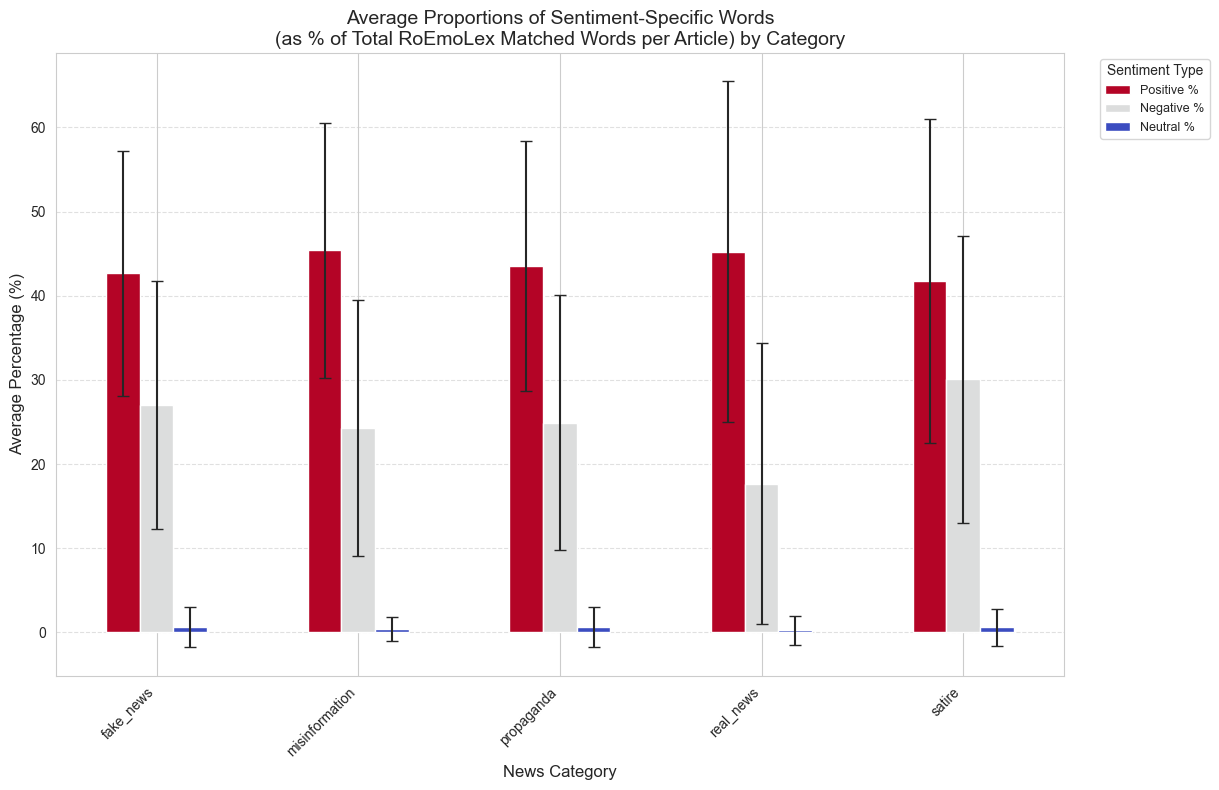

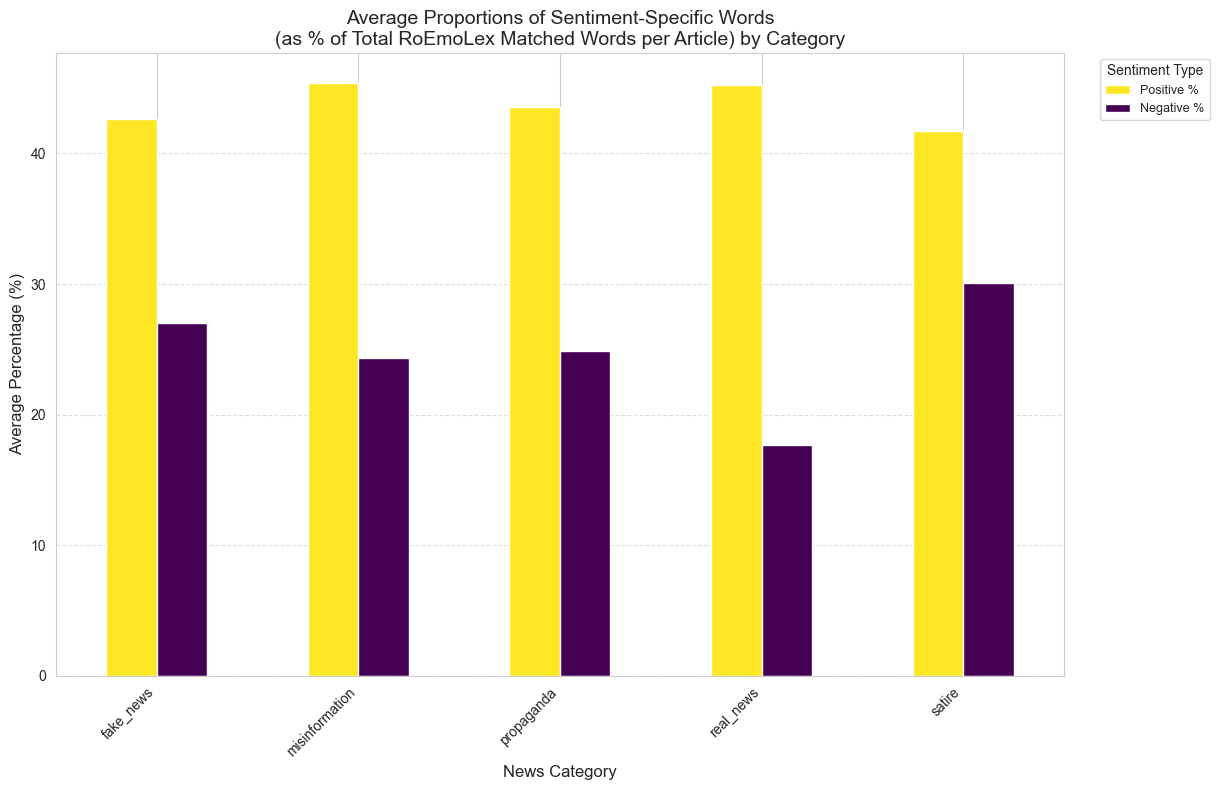

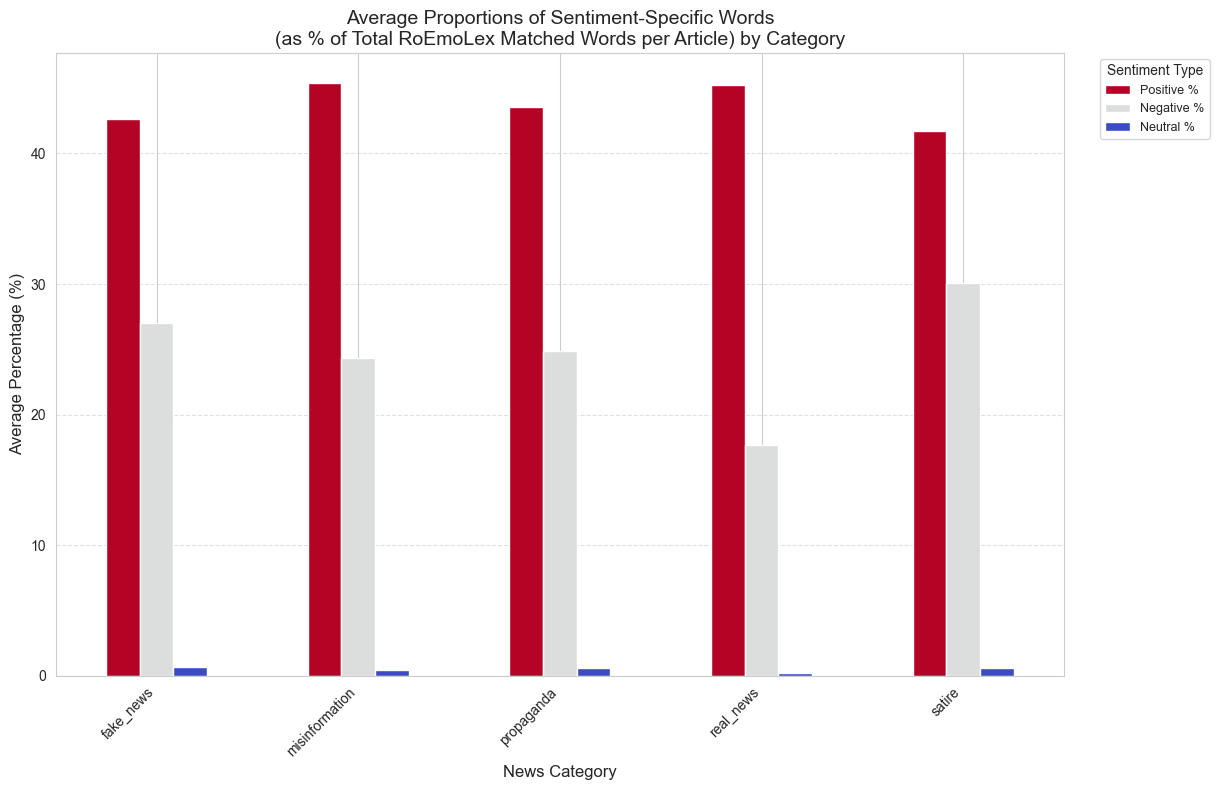

In [33]:
plt.figure(figsize=(14, 8))
sentiment_proportion_mean.plot(
    kind='bar',
    ax=plt.gca(),
    yerr=sentiment_proportion_std,
    capsize=4,
    colormap='coolwarm_r'
)
plt.title('Average Proportions of Sentiment-Specific Words\n(as % of Total RoEmoLex Matched Words per Article) by Category', fontsize=14)
plt.xlabel('News Category', fontsize=12)
plt.ylabel('Average Percentage (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment Type', bbox_to_anchor=(1.03, 1), loc='upper left', title_fontsize='10', fontsize='9')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.savefig(os.path.join(EMOTION_DIR, 'sentiment_mean_std_yerror_bar.png'), bbox_inches='tight')

plt.figure(figsize=(14, 8))
sentiment_proportion_mean[['Positive %', 'Negative %']
].plot(
    kind='bar',
    ax=plt.gca(),
    capsize=4,
    colormap='viridis_r'
)
plt.title('Average Proportions of Sentiment-Specific Words\n(as % of Total RoEmoLex Matched Words per Article) by Category', fontsize=14)
plt.xlabel('News Category', fontsize=12)
plt.ylabel('Average Percentage (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment Type', bbox_to_anchor=(1.03, 1), loc='upper left', title_fontsize='10', fontsize='9')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.savefig(os.path.join(EMOTION_DIR, 'sentiment_mean_positive_negative_bar.png'), bbox_inches='tight')

plt.figure(figsize=(14, 8))
sentiment_proportion_mean.plot(
    kind='bar',
    ax=plt.gca(),
    capsize=4,
    colormap='coolwarm_r'
)
plt.title('Average Proportions of Sentiment-Specific Words\n(as % of Total RoEmoLex Matched Words per Article) by Category', fontsize=14)
plt.xlabel('News Category', fontsize=12)
plt.ylabel('Average Percentage (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment Type', bbox_to_anchor=(1.03, 1), loc='upper left', title_fontsize='10', fontsize='9')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.savefig(os.path.join(EMOTION_DIR, 'sentiment_mean_bar.png'), bbox_inches='tight')

#### Calculate Overall Scores for Each Emotion Across All Documents

In [26]:
if 'df_processed' in locals() and df_processed is not None:
    try:
        if 'EMOTION_COLS' not in locals():
            EMOTION_COLS = ['Anger', 'Anticipation', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust']
            print("Warning: EMOTION_COLS was not in local scope, defined it as default.")

        missing_emotion_cols = [col for col in EMOTION_COLS if col not in df_processed.columns]

        if not missing_emotion_cols:
            print("\n--- Calculating Overall Standard Deviation for Each Emotion Score (Count of Words) ---")
            overall_emotion_std = df_processed[EMOTION_COLS].std()
            overall_emotion_mean = df_processed[EMOTION_COLS].mean()
            print("\nOverall Mean for each emotion across all documents:")
            print(overall_emotion_mean)
            print("\nStandard Deviation for each emotion across all documents:")
            print(overall_emotion_std)
            
        else:
            print(f"Error: The following emotion columns are missing from df_processed: {missing_emotion_cols}")
            print("Please ensure the emotion scoring cell (ID: 1b7cfc031f39c9af or similar) has been run successfully to create these columns.")

    except NameError as e:
        print(f"Error: A required variable (likely EMOTION_COLS) is not defined. {e}")
        print("Please ensure the cell defining EMOTION_COLS (ID: c17553ef78a69485 or similar) has been run.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
else:
    print("Error: df_processed DataFrame not found. Please run the preceding cells in the notebook to create it.")


--- Calculating Overall Standard Deviation for Each Emotion Score (Count of Words) ---

Overall Mean for each emotion across all documents:
Anger            4.420858
Anticipation     8.940240
Disgust          2.527457
Fear             6.892017
Joy              3.537840
Sadness          4.499539
Surprise         2.153207
Trust           13.815874
dtype: float64

Standard Deviation for each emotion across all documents:
Anger            8.232575
Anticipation    14.441663
Disgust          5.395980
Fear            13.141400
Joy              5.921350
Sadness          9.199528
Surprise         4.293692
Trust           21.423058
dtype: float64



--- Plotting Overall Mean for Each Emotion Word Count ---
Saved overall emotion mean bar chart to: C:\Users\Razvan\projects\university\romanian-fake-news-detection\visualizations\dataset_analysis\emotion_analysis\overall_emotion_mean_bar.png

--- Plotting Overall Standard Deviation for Each Emotion Word Count ---
Saved overall emotion standard deviation bar chart to: C:\Users\Razvan\projects\university\romanian-fake-news-detection\visualizations\dataset_analysis\emotion_analysis\overall_emotion_std_dev_bar.png


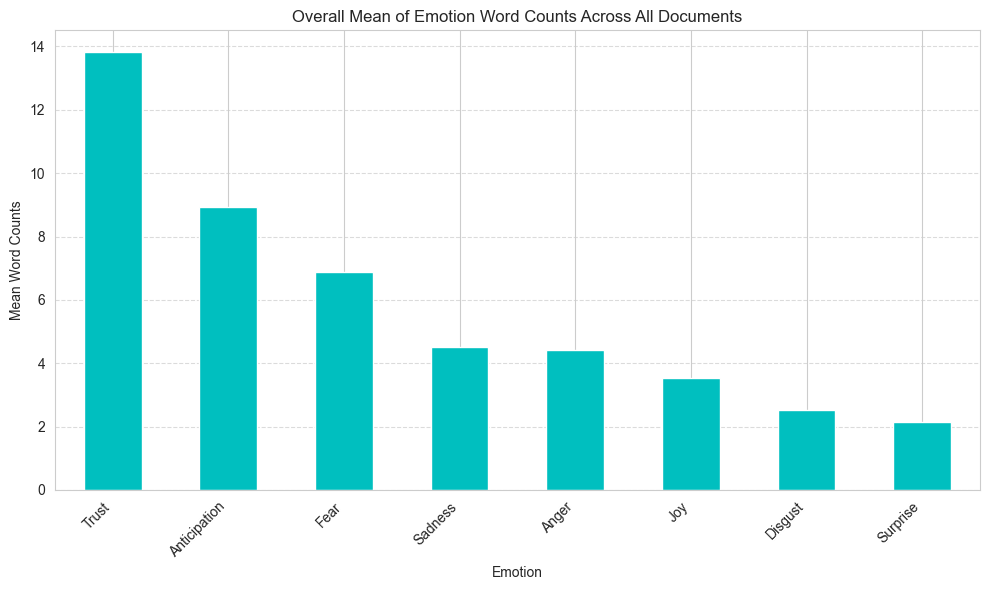

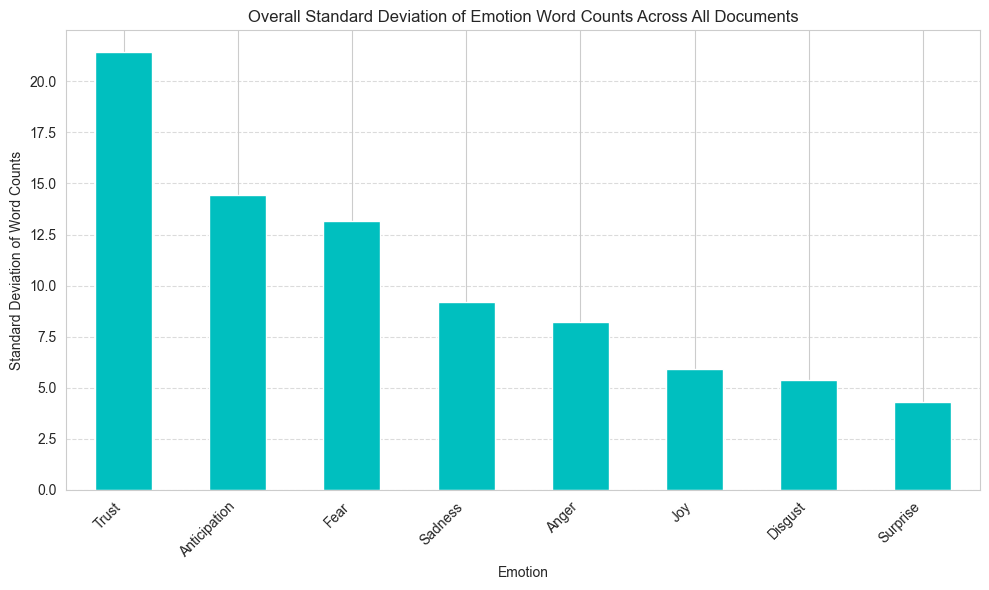

In [27]:
if 'overall_emotion_mean' in locals() and isinstance(overall_emotion_mean, pd.Series):
    print("\n--- Plotting Overall Mean for Each Emotion Word Count ---")
    try:
        plt.figure(figsize=(10, 6))
        overall_emotion_mean.sort_values(ascending=False).plot(kind='bar', color='c')
        plt.title('Overall Mean of Emotion Word Counts Across All Documents')
        plt.xlabel('Emotion')
        plt.ylabel('Mean Word Counts')
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig(os.path.join(EMOTION_DIR, 'overall_emotion_mean_bar.png'), bbox_inches='tight')
        print(f"Saved overall emotion mean bar chart to: {os.path.join(EMOTION_DIR, 'overall_emotion_mean_bar.png')}")
    except Exception as e:
        print(f"Error plotting overall emotion mean: {e}")
else:
    print("\n'overall_emotion_mean' (Pandas Series) not found or not in the correct format.")
    print("Please ensure the previous cell that calculates it has been run successfully.")

if 'overall_emotion_std' in locals() and isinstance(overall_emotion_std, pd.Series):
    print("\n--- Plotting Overall Standard Deviation for Each Emotion Word Count ---")
    try:
        plt.figure(figsize=(10, 6))
        overall_emotion_std.sort_values(ascending=False).plot(kind='bar', color='c')
        plt.title('Overall Standard Deviation of Emotion Word Counts Across All Documents')
        plt.xlabel('Emotion')
        plt.ylabel('Standard Deviation of Word Counts')
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig(os.path.join(EMOTION_DIR, 'overall_emotion_std_dev_bar.png'), bbox_inches='tight')
        print(f"Saved overall emotion standard deviation bar chart to: {os.path.join(EMOTION_DIR, 'overall_emotion_std_dev_bar.png')}")
    except Exception as e:
        print(f"Error plotting overall emotion standard deviation: {e}")
else:
    print("\n'overall_emotion_std' (Pandas Series) not found or not in the correct format.")
    print("Please ensure the previous cell that calculates it has been run successfully.")

#### Exclusive Emotion Analysis

In [28]:
def calculate_exclusive_emotion_counts_per_doc(lemma_list, exclusive_mapping):
    doc_exclusive_scores = {emotion: 0 for emotion in EMOTION_COLS}
    doc_exclusive_scores.update({polarity: 0 for polarity in POLARITY_COLS})
    
    matched_exclusive_emotion_words_count = 0

    if not isinstance(lemma_list, list):
        doc_exclusive_scores['matched_exclusive_emotion_words'] = 0
        return doc_exclusive_scores

    for lemma in lemma_list:
        lemma_lower = lemma.lower()
        if lemma_lower in exclusive_mapping:
            lemma_exclusive_scores = exclusive_mapping[lemma_lower]
            word_matched_an_emotion_this_time = False
            for emotion in EMOTION_COLS:
                if lemma_exclusive_scores.get(emotion, 0) > 0:
                    doc_exclusive_scores[emotion] += 1
                    word_matched_an_emotion_this_time = True
            
            if word_matched_an_emotion_this_time:
                matched_exclusive_emotion_words_count +=1

            for polarity in POLARITY_COLS:
                if lemma_exclusive_scores.get(polarity, 0) > 0:
                     doc_exclusive_scores[polarity] += lemma_exclusive_scores[polarity]
    
    doc_exclusive_scores['matched_exclusive_emotion_words'] = matched_exclusive_emotion_words_count
    return doc_exclusive_scores

In [29]:
if 'df_processed' not in locals() or df_processed is None:
    print("Error: df_processed DataFrame not found. Please run previous cells to load/create it.")
elif 'roemo_dict' not in locals() or not roemo_dict:
    print("Error: roemo_dict not found or empty. Please run RoEmoLex loading cells.")
elif 'lemmas' not in df_processed.columns:
    print("Error: 'lemmas' column not found in df_processed.")
else:
    print("\nCreating Exclusive RoEmoLex Mapping...")
    EMOTION_COLS = ['Anger', 'Anticipation', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust']
    POLARITY_COLS = ['Positivity', 'Negativity']

    EMOTION_PRIORITY = ['Anger', 'Disgust', 'Fear', 'Sadness', 'Surprise', 'Anticipation', 'Joy', 'Trust']

    exclusive_roemo_mapping = {}
    for lemma, scores in roemo_dict.items():
        assigned_emotion = None
        for emotion in EMOTION_PRIORITY:
            if scores.get(emotion, 0) > 0:
                assigned_emotion = emotion
                break # Assign only to the first emotion found in the priority list

        exclusive_scores = {emotion: 0 for emotion in EMOTION_COLS}
        if assigned_emotion:
            exclusive_scores[assigned_emotion] = 1

        for polarity in POLARITY_COLS:
            exclusive_scores[polarity] = scores.get(polarity, 0)
        
        exclusive_roemo_mapping[lemma] = exclusive_scores

    print(f"Exclusive RoEmoLex mapping created for {len(exclusive_roemo_mapping)} lemmas.")
    if exclusive_roemo_mapping:
        sample_lemma_exclusive = list(exclusive_roemo_mapping.keys())[0]
        print(f"Sample entry (original) for '{sample_lemma_exclusive}': {roemo_dict.get(sample_lemma_exclusive)}")
        print(f"Sample entry (exclusive) for '{sample_lemma_exclusive}': {exclusive_roemo_mapping[sample_lemma_exclusive]}")


    print("\nCalculating Exclusive Emotion Counts per Document...")

    exclusive_emotion_data = []
    for lemmas_in_doc in df_processed['lemmas']:
        exclusive_emotion_data.append(
            calculate_exclusive_emotion_counts_per_doc(lemmas_in_doc, exclusive_roemo_mapping)
        )
    
    exclusive_emotion_df = pd.DataFrame(exclusive_emotion_data)
    
    for col in EMOTION_COLS + POLARITY_COLS + ['matched_exclusive_emotion_words']:
        df_processed[f'{col}_exclusive'] = exclusive_emotion_df[col]

    print("Exclusive emotion and polarity count columns added to DataFrame")

    print("\nAggregating Exclusive Emotion Statistics per Category...")
    exclusive_emotion_cols_for_agg = [f'{col}_exclusive' for col in EMOTION_COLS]
    
    exclusive_emotion_stats_agg = df_processed.groupby('tag')[exclusive_emotion_cols_for_agg].agg(
        ['mean', 'std', 'min', 'max']
    )
    print("\nAggregated Exclusive Emotion Statistics per News Category (Word Counts):")
    print(exclusive_emotion_stats_agg)


Creating Exclusive RoEmoLex Mapping...
Exclusive RoEmoLex mapping created for 6330 lemmas.
Sample entry (original) for 'se izbi': {'Anger': 0, 'Anticipation': 0, 'Disgust': 0, 'Fear': 1, 'Joy': 0, 'Sadness': 1, 'Surprise': 1, 'Trust': 0, 'Positivity': 0, 'Negativity': 1}
Sample entry (exclusive) for 'se izbi': {'Anger': 0, 'Anticipation': 0, 'Disgust': 0, 'Fear': 1, 'Joy': 0, 'Sadness': 0, 'Surprise': 0, 'Trust': 0, 'Positivity': 0, 'Negativity': 1}

Calculating Exclusive Emotion Counts per Document...
Exclusive emotion and polarity count columns added to DataFrame

Aggregating Exclusive Emotion Statistics per Category...

Aggregated Exclusive Emotion Statistics per News Category (Word Counts):
               Anger_exclusive                     Anticipation_exclusive  \
                          mean        std min  max                   mean   
tag                                                                         
fake_news             6.850985  12.533210   0   88              

#### Plot Exclusive Emotion Statistics


Visualizing Exclusive Emotion Statistics...
Saved exclusive emotion mean bar chart to: C:\Users\Razvan\projects\university\romanian-fake-news-detection\visualizations\dataset_analysis\emotion_analysis\exclusive_emotion_mean_bar.png


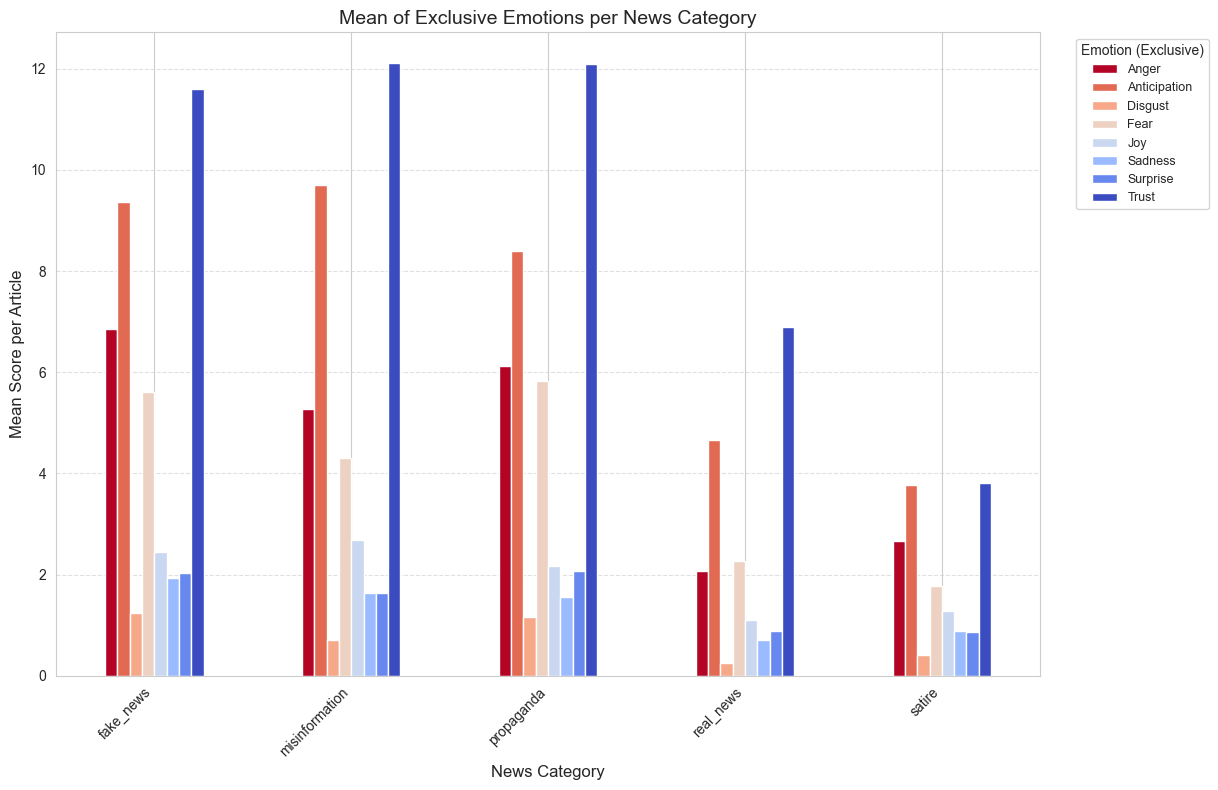

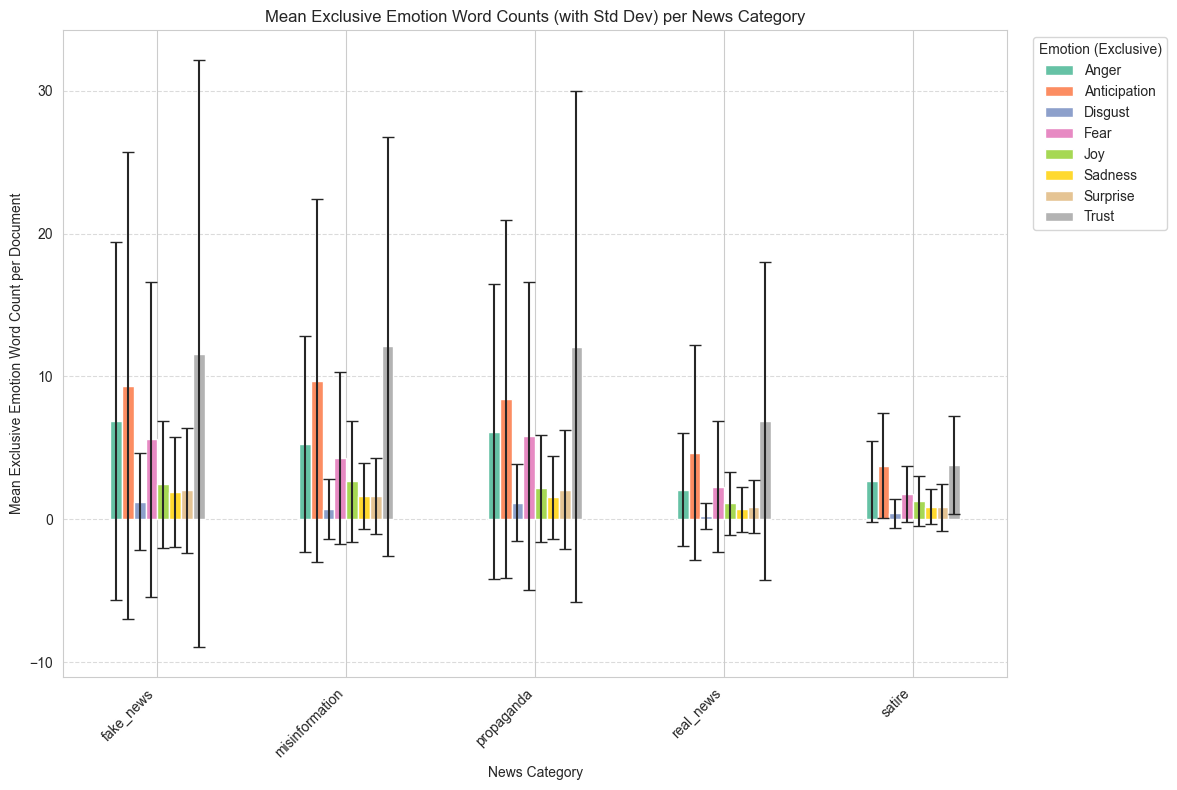

In [30]:
if 'exclusive_emotion_stats_agg' in locals() and isinstance(exclusive_emotion_stats_agg, pd.DataFrame):
    print("\nVisualizing Exclusive Emotion Statistics...")
    exclusive_emotion_mean = exclusive_emotion_stats_agg.xs('mean', axis=1, level=1)
    exclusive_emotion_std = exclusive_emotion_stats_agg.xs('std', axis=1, level=1)

    exclusive_emotion_mean.columns = EMOTION_COLS
    exclusive_emotion_std.columns = EMOTION_COLS
    
    plt.figure(figsize=(14, 8))
    exclusive_emotion_mean.plot(
        kind='bar',
        ax=plt.gca(),
        capsize=4,
        colormap='coolwarm_r'
    )
    plt.title('Mean of Exclusive Emotions per News Category', fontsize=14)
    plt.xlabel('News Category', fontsize=12)
    plt.ylabel('Mean Score per Article', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Emotion (Exclusive)', bbox_to_anchor=(1.03, 1), loc='upper left', title_fontsize='10', fontsize='9')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout(rect=[0, 0, 0.88, 1])
    plt.savefig(os.path.join(EMOTION_DIR, 'exclusive_emotion_mean_bar.png'), bbox_inches='tight')


    plt.figure(figsize=(14, 8))
    exclusive_emotion_mean.plot(
        kind='bar', 
        ax=plt.gca(),
        yerr=exclusive_emotion_std, 
        capsize=4,
        colormap='Set2'
    )
    plt.title('Mean Exclusive Emotion Word Counts (with Std Dev) per News Category')
    plt.xlabel('News Category')
    plt.ylabel('Mean Exclusive Emotion Word Count per Document')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Emotion (Exclusive)', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.savefig(os.path.join(EMOTION_DIR, 'exclusive_emotion_mean_stderr_bar.png'), bbox_inches='tight')
    print(f"Saved exclusive emotion mean bar chart to: {os.path.join(EMOTION_DIR, 'exclusive_emotion_mean_bar.png')}")
else:
    print("\n'exclusive_emotion_stats_agg' (Pandas DataFrame) not found or not in the correct format.")
    print("Please ensure the exclusive emotion analysis cell has been run successfully.")

# Save Final Processed DataFrame

In [31]:
output_path = os.path.join(BASE_DIR, 'data', 'processed', 'final_NEW.csv')
df_processed.to_csv(output_path, index=False, encoding='utf-8')

# Word Clouds

#### Configurations 

In [153]:
WC_WIDTH = 800
WC_HEIGHT = 400
WC_BACKGROUND = "white"
WC_COLORMAP = "viridis"
WC_MAX_WORDS = 100
GENERIC_WORDS = ['face', 'zi', 'spune', 'lua', 'pune', 'sex', 'mamă', 'bine', 'vinde', 'nevoie',
                 'abia', 'purta', 'simplu', 'atinge', 'fugă', 'vorbi', 'lucru', 'ajunge', 
                 'duce', 'vorbă', 'aproape', 'trece', 'treabă', 'formă', 'om', 'fi', 'https', 
                 'așa', 'precum', 'ru', 'acesta', 'atat', 'afla'] # Generic words to exclude from word clouds

In [154]:
if 'df_processed' not in locals() or df_processed is None:
    print("Error: df_processed DataFrame not found. Please run previous analysis steps.")
    exit()
if 'lemmas_filtered' not in df_processed.columns:
    print("Error: 'lemmas_filtered' column not found. Rerun preprocessing steps.")
    exit()
if not isinstance(df_processed['lemmas_filtered'].iloc[0], list):
     print("Warning: 'lemmas_filtered' column might not be parsed as lists. Attempting conversion...")
     try:
         df_processed['lemmas_filtered'] = df_processed['lemmas_filtered'].apply(parse_list_literal)
         if not isinstance(df_processed['lemmas_filtered'].iloc[0], list):
              raise ValueError("Conversion failed")
         print("'lemmas_filtered' column converted to lists.")
     except Exception as e:
          print(f"Error converting 'lemmas_filtered': {e}. Word cloud generation may fail.")

can_generate_emotional_clouds = 'roemo_dict' in locals() and bool(roemo_dict)
if not can_generate_emotional_clouds:
    print("\nWarning: RoEmoLex dictionary ('roemo_dict') not found or empty. Skipping emotional word clouds.")

#### Standard Word Clouds per Category

In [155]:
categories = df_processed['tag'].unique()

for category in categories:
    print(f"\nProcessing category: {category}")

    df_category = df_processed[df_processed['tag'] == category]

    all_lemmas_list = []
    try:
        for lemma_list in df_category['lemmas_filtered']:
             if isinstance(lemma_list, list):
                 all_lemmas_list.extend(lemma_list)

        all_lemmas_list = [lemma for lemma in all_lemmas_list if lemma not in GENERIC_WORDS]
        text_standard = " ".join(all_lemmas_list)

        if not text_standard:
            print(f"  - No words found for standard word cloud in category '{category}'. Skipping.")
        else:
            print(f"  - Generating standard word cloud for '{category}'...")
            wordcloud_standard = WordCloud(width=WC_WIDTH, height=WC_HEIGHT,
                                           background_color=WC_BACKGROUND,
                                           colormap=WC_COLORMAP,
                                           max_words=WC_MAX_WORDS,
                                           contour_width=1, contour_color='steelblue',
                                           collocations=False
                                           ).generate(text_standard)

            plt.figure(figsize=(10, 5))
            plt.imshow(wordcloud_standard, interpolation='bilinear')
            plt.axis("off")
            plt.title(f"Standard Word Cloud - {category}", fontsize=14)
            std_wc_filename = f"standard_wc_{category.replace(' ', '_')}.png"
            plt.savefig(os.path.join(WORDCLOUD_DIR, std_wc_filename), bbox_inches='tight')
            print(f"  - Saved standard word cloud to: {WORDCLOUD_DIR}")
            plt.close()

    except Exception as e:
        print(f"  - Error generating standard word cloud for '{category}': {e}")
        import traceback
        traceback.print_exc()

    if can_generate_emotional_clouds:
        try:
            emotional_lemmas_list = [lemma for lemma in all_lemmas_list if lemma in roemo_dict]

            emotional_lemmas_list = [lemma for lemma in emotional_lemmas_list if lemma not in GENERIC_WORDS]
            text_emotional = " ".join(emotional_lemmas_list)
            
            predominant_emotion_info = "N/A"
            category_emotion_counts = Counter()
            
            if 'EMOTION_COLS' not in locals():
                EMOTION_COLS = ['Anger', 'Anticipation', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust']
                print("EMOTION_COLS not found. Using default values.")
                
            for lemma in emotional_lemmas_list:
                if lemma in roemo_dict:
                    scores = roemo_dict[lemma]
                    for emotion_col in EMOTION_COLS:
                        if scores.get(emotion_col, 0) > 0:
                            category_emotion_counts[emotion_col] += 1
                            
            if category_emotion_counts:
                max_count = 0
                for emotion in EMOTION_COLS:
                    if category_emotion_counts[emotion] > max_count:
                        max_count = category_emotion_counts[emotion]
                        predominant_emotion_info = emotion
                        
                predominant_emotions = [emo for emo, count in category_emotion_counts.items() if count == max_count and count > 0]
                
                if predominant_emotions:
                    predominant_emotion_info = ', '.join(predominant_emotions)
                    print(f"  - Predominant emotion(s) for '{category}' in filtered lemmas list: {predominant_emotion_info} (Count: {max_count})")
                    print("\nCategory Emotion Counts: ", [f"{emo}: {count}" for emo, count in category_emotion_counts.items()])
                else:
                    print(f"  - No emotions scored significantly for words in '{category}' emotional word cloud list.")
            else:
                print(f"  - No RoEmoLex emotions found for words in '{category}' emotional word cloud list.")
            
            
            if not text_emotional:
                print(f"  - No emotional words found for word cloud in category '{category}'. Skipping.")
            else:
                print(f"  - Generating emotional word cloud for '{category}'...")
                wordcloud_emotional = WordCloud(width=WC_WIDTH, height=WC_HEIGHT,
                                                background_color=WC_BACKGROUND,
                                                colormap=WC_COLORMAP,
                                                max_words=WC_MAX_WORDS,
                                                contour_width=1, contour_color='firebrick',
                                                collocations=False
                                                ).generate(text_emotional)
                
                words_in_cloud = list(wordcloud_emotional.words_.keys())
                predominant_emotion_info = 'N/A'
                wc_title_suffix = ""
                
                if not words_in_cloud:
                    print(f"  - No words were placed in the word cloud for '{category}'.")
                else:
                    category_emotion_counts_from_cloud = Counter()
                    if 'EMOTION_COLS' not in locals():
                        EMOTION_COLS = ['Anger', 'Anticipation', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust']
                        print("Warning: EMOTION_COLS was not defined. Using default list.")
        
                    for lemma_in_cloud in words_in_cloud:
                        if lemma_in_cloud in roemo_dict:
                            scores = roemo_dict[lemma_in_cloud]
                            for emotion_col in EMOTION_COLS:
                                if scores.get(emotion_col, 0) > 0:
                                    category_emotion_counts_from_cloud[emotion_col] += 1
                    
                    if category_emotion_counts_from_cloud:
                        max_count = 0
                        for emotion in EMOTION_COLS: 
                            if category_emotion_counts_from_cloud[emotion] > max_count:
                                max_count = category_emotion_counts_from_cloud[emotion]
                        
                        predominant_emotions_in_cloud = [emo for emo, count in category_emotion_counts_from_cloud.items() if count == max_count and count > 0]
                        
                        if predominant_emotions_in_cloud:
                            predominant_emotion_info = ", ".join(predominant_emotions_in_cloud)
                            print(f"  - Predominant emotion(s) in the generated word cloud for '{category}': {predominant_emotion_info} (Sum of word occurrences in cloud: {max_count})")
                            wc_title_suffix = f" (Predominant: {predominant_emotion_info})"
                            print("\nCategory Emotion Counts in Word Cloud: ", [f"{emo}: {count}" for emo, count in category_emotion_counts_from_cloud.items()])

                        else:
                            print(f"  - No RoEmoLex emotions strongly represented by words in the generated cloud for '{category}'.")
                    else:
                        print(f"  - Words in cloud for '{category}' did not map to any RoEmoLex emotions.")
                
                plt.figure(figsize=(10, 5))
                plt.imshow(wordcloud_emotional, interpolation='bilinear')
                plt.axis("off")
                plt.title(f"Emotional Word Cloud (RoEmoLex) - {category}{wc_title_suffix}", fontsize=14)
                emo_wc_filename = f"standard_emotional_wc_{category.replace(' ', '_')}.png"
                plt.savefig(os.path.join(EMOTIONAL_WORDCLOUD_DIR, emo_wc_filename), bbox_inches='tight')
                print(f"  - Saved emotional word cloud to: {EMOTIONAL_WORDCLOUD_DIR}")
                plt.close()

        except Exception as e:
            print(f"  - Error generating emotional word cloud for '{category}': {e}")
            import traceback
            traceback.print_exc()

print("\n--- Word cloud generation complete. ---")


Processing category: fake_news
  - Generating standard word cloud for 'fake_news'...
  - Saved standard word cloud to: C:\Users\Razvan\projects\university\romanian-fake-news-detection\visualizations\dataset_analysis\word_clouds
  - Predominant emotion(s) for 'fake_news' in filtered lemmas list: Trust (Count: 11491)

Category Emotion Counts:  ['Anger: 4260', 'Fear: 7337', 'Joy: 3198', 'Trust: 11491', 'Anticipation: 6830', 'Sadness: 5094', 'Disgust: 2383', 'Surprise: 2006']
  - Generating emotional word cloud for 'fake_news'...
  - Predominant emotion(s) in the generated word cloud for 'fake_news': Trust (Sum of word occurrences in cloud: 32)

Category Emotion Counts in Word Cloud:  ['Trust: 32', 'Fear: 16', 'Sadness: 8', 'Anger: 8', 'Disgust: 6', 'Anticipation: 24', 'Joy: 5', 'Surprise: 4']
  - Saved emotional word cloud to: C:\Users\Razvan\projects\university\romanian-fake-news-detection\visualizations\dataset_analysis\emotion_analysis\emotional_wordclouds

Processing category: misinf

#### Emotion & Sentiment Specific Words - List Initialization 

In [156]:
EMOTION_COLS = ['Anger', 'Anticipation', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust']
POLARITY_COLS = ['Positivity', 'Negativity']

emotion_word_lists = {emotion: [] for emotion in EMOTION_COLS}
sentiment_word_lists = {sentiment: [] for sentiment in ['Positive', 'Negative', 'Neutral']}

if 'df_processed' in locals() and df_processed is not None and 'roemo_dict' in locals() and roemo_dict:
    print("Processing documents for emotion and sentiment words...")
    for lemma_list in df_processed['lemmas']:
        if not isinstance(lemma_list, list):
            continue
        for lemma in lemma_list:
            lemma_lower = lemma.lower()
            if lemma_lower in roemo_dict:
                scores = roemo_dict[lemma_lower]

                for emotion in EMOTION_COLS:
                    if scores.get(emotion, 0) > 0: # RoEmoLex scores are 0 or 1
                        emotion_word_lists[emotion].append(lemma_lower)

                is_positive = scores.get('Positivity', 0) > 0
                is_negative = scores.get('Negativity', 0) > 0

                if is_positive and is_negative:
                    sentiment_word_lists['Neutral'].append(lemma_lower)
                elif is_positive:
                    sentiment_word_lists['Positive'].append(lemma_lower)
                elif is_negative:
                    sentiment_word_lists['Negative'].append(lemma_lower)
    print("Document processing complete.")
else:
    if 'df_processed' not in locals() or df_processed is None:
        print("Error: df_processed DataFrame not found. Please ensure previous cells have run successfully.")
    if 'roemo_dict' not in locals() or not roemo_dict:
        print("Error: roemo_dict not found or empty. Please ensure RoEmoLex lexicon was loaded successfully.")

Processing documents for emotion and sentiment words...
Document processing complete.


#### Plot Emotion Specific Word Clouds

In [157]:
for emotion, words in emotion_word_lists.items():
    if words:
        words = [lemma for lemma in words if lemma not in GENERIC_WORDS]
        text = " ".join(words)
        try:
            wordcloud = WordCloud(width=WC_WIDTH, height=WC_HEIGHT,
                                  background_color=WC_BACKGROUND,
                                  colormap=WC_COLORMAP,
                                  max_words=WC_MAX_WORDS,
                                  collocations=False).generate(text)
            plt.figure(figsize=(10, 5))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis("off")
            plt.title(f"Emotion: {emotion}", fontsize=14)
            filename = f"generic_emotion_wc_{emotion.replace(' ', '_')}.png"
            plt.savefig(os.path.join(EMOTIONAL_WORDCLOUD_DIR, filename), bbox_inches='tight')
            plt.close()
            print(f"  - Saved word cloud for {emotion} to {EMOTIONAL_WORDCLOUD_DIR}")
        except Exception as e:
            print(f"  - Error generating word cloud for emotion '{emotion}': {e}")
    else:
        print(f"  - No words found for emotion '{emotion}', skipping word cloud.")

  - Saved word cloud for Anger to C:\Users\Razvan\projects\university\romanian-fake-news-detection\visualizations\dataset_analysis\emotion_analysis\emotional_wordclouds
  - Saved word cloud for Anticipation to C:\Users\Razvan\projects\university\romanian-fake-news-detection\visualizations\dataset_analysis\emotion_analysis\emotional_wordclouds
  - Saved word cloud for Disgust to C:\Users\Razvan\projects\university\romanian-fake-news-detection\visualizations\dataset_analysis\emotion_analysis\emotional_wordclouds
  - Saved word cloud for Fear to C:\Users\Razvan\projects\university\romanian-fake-news-detection\visualizations\dataset_analysis\emotion_analysis\emotional_wordclouds
  - Saved word cloud for Joy to C:\Users\Razvan\projects\university\romanian-fake-news-detection\visualizations\dataset_analysis\emotion_analysis\emotional_wordclouds
  - Saved word cloud for Sadness to C:\Users\Razvan\projects\university\romanian-fake-news-detection\visualizations\dataset_analysis\emotion_analysis

#### Plot Sentiment Specific Word Clouds

In [158]:
for sentiment, words in sentiment_word_lists.items():
    if words:
        words = [lemma for lemma in words if lemma not in GENERIC_WORDS]
        text = " ".join(words)
        try:
            wordcloud = WordCloud(width=WC_WIDTH, height=WC_HEIGHT,
                                  background_color=WC_BACKGROUND,
                                  colormap=WC_COLORMAP,
                                  max_words=WC_MAX_WORDS,
                                  collocations=False).generate(text)
            plt.figure(figsize=(10, 5))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis("off")
            plt.title(f"Sentiment: {sentiment}", fontsize=14)
            filename = f"sentiment_wc_{sentiment.replace(' ', '_')}.png"
            plt.savefig(os.path.join(EMOTIONAL_WORDCLOUD_DIR, filename), bbox_inches='tight')
            plt.close()
            print(f"  - Saved word cloud for {sentiment} to {EMOTIONAL_WORDCLOUD_DIR}")
        except Exception as e:
            print(f"  - Error generating word cloud for sentiment '{sentiment}': {e}")
    else:
        print(f"  - No words found for sentiment '{sentiment}', skipping word cloud.")

  - Saved word cloud for Positive to C:\Users\Razvan\projects\university\romanian-fake-news-detection\visualizations\dataset_analysis\emotion_analysis\emotional_wordclouds
  - Saved word cloud for Negative to C:\Users\Razvan\projects\university\romanian-fake-news-detection\visualizations\dataset_analysis\emotion_analysis\emotional_wordclouds
  - Saved word cloud for Neutral to C:\Users\Razvan\projects\university\romanian-fake-news-detection\visualizations\dataset_analysis\emotion_analysis\emotional_wordclouds


#### Generate Exclusive Emotion Word Clouds

  - Saved word cloud for exclusive emotion 'Anger' to C:\Users\Razvan\projects\university\romanian-fake-news-detection\visualizations\dataset_analysis\emotion_analysis\emotional_wordclouds
  - Saved word cloud for exclusive emotion 'Anticipation' to C:\Users\Razvan\projects\university\romanian-fake-news-detection\visualizations\dataset_analysis\emotion_analysis\emotional_wordclouds
  - Saved word cloud for exclusive emotion 'Disgust' to C:\Users\Razvan\projects\university\romanian-fake-news-detection\visualizations\dataset_analysis\emotion_analysis\emotional_wordclouds
  - Saved word cloud for exclusive emotion 'Fear' to C:\Users\Razvan\projects\university\romanian-fake-news-detection\visualizations\dataset_analysis\emotion_analysis\emotional_wordclouds
  - Saved word cloud for exclusive emotion 'Joy' to C:\Users\Razvan\projects\university\romanian-fake-news-detection\visualizations\dataset_analysis\emotion_analysis\emotional_wordclouds
  - Saved word cloud for exclusive emotion 'Sadne

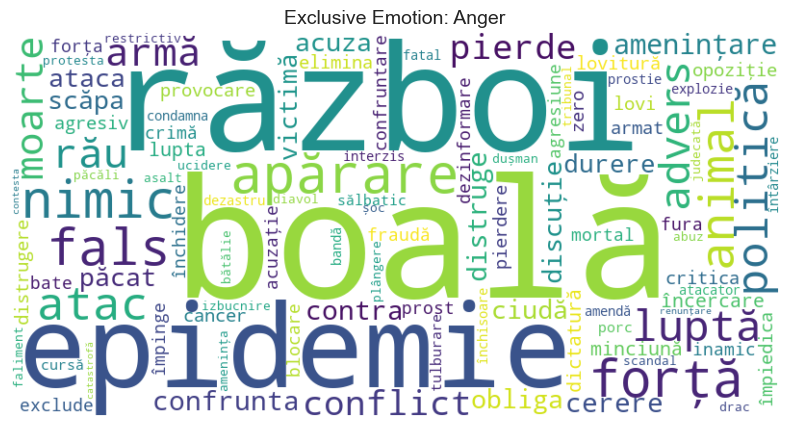

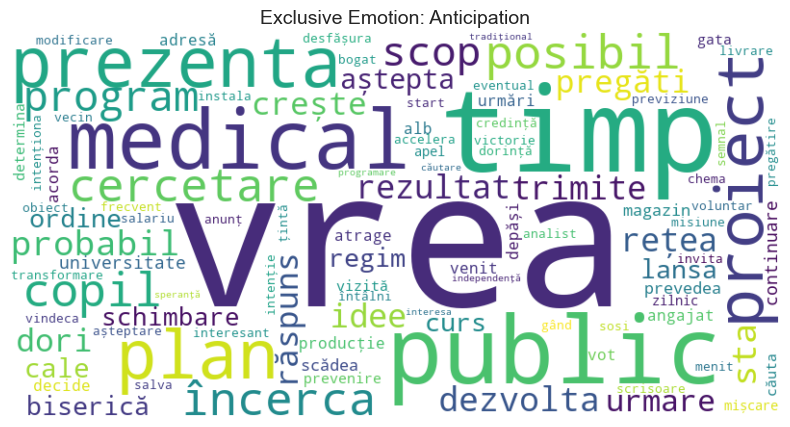

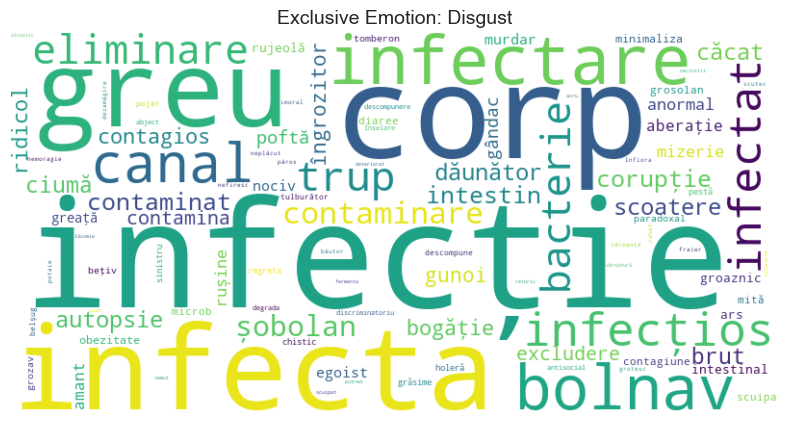

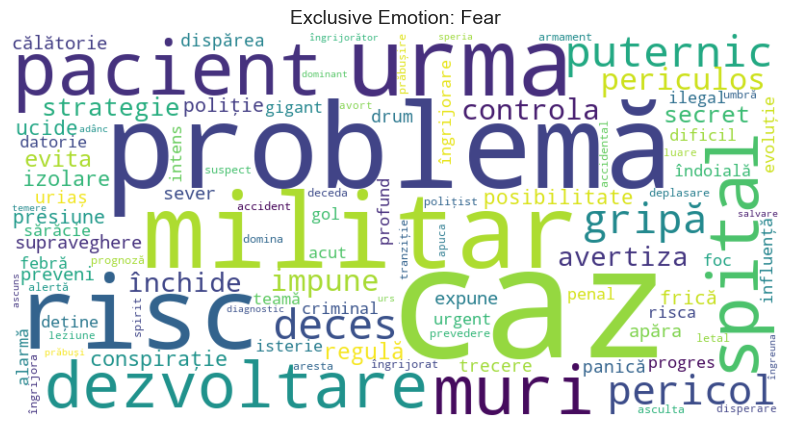

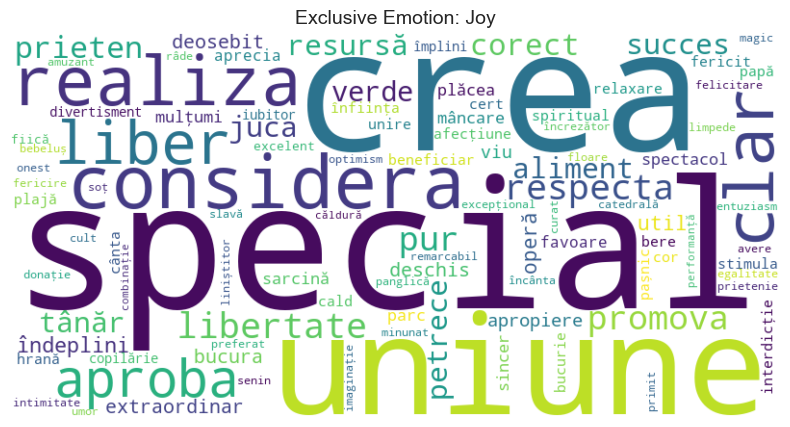

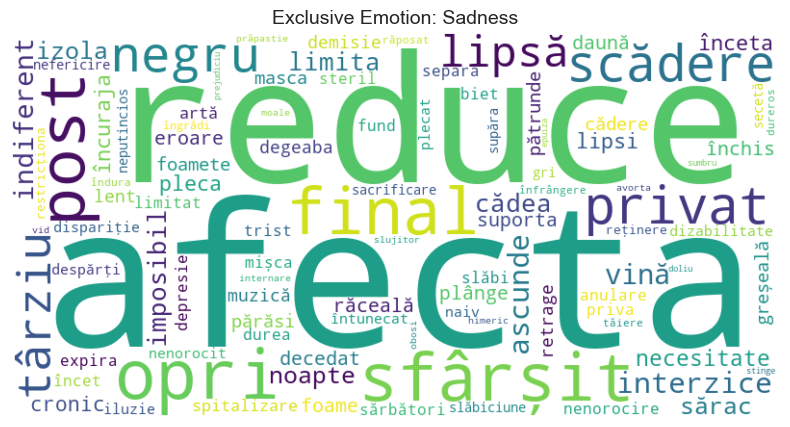

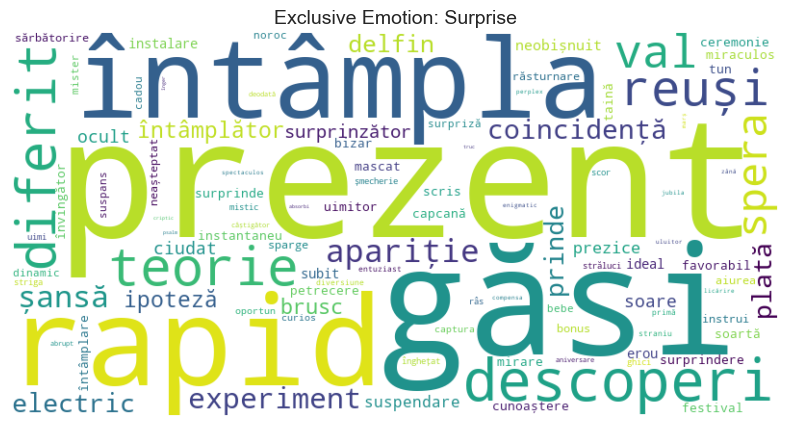

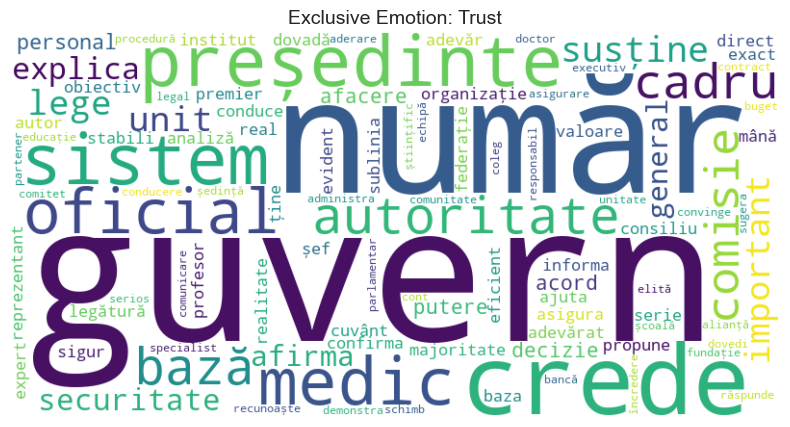

In [159]:
exclusive_emotion_word_lists = {emotion: [] for emotion in EMOTION_COLS}

for lemma_list in df_processed['lemmas']:
    if not isinstance(lemma_list, list):
        continue
    for lemma in lemma_list:
        lemma_lower = lemma.lower()
        if lemma_lower in exclusive_roemo_mapping:
            assigned_scores = exclusive_roemo_mapping[lemma_lower]
            for emotion in EMOTION_COLS:
                if assigned_scores.get(emotion, 0) > 0:
                    exclusive_emotion_word_lists[emotion].append(lemma_lower)
                    break

for emotion, words in exclusive_emotion_word_lists.items():
    if words:
        words = [word for word in words if word not in GENERIC_WORDS]
        text = " ".join(words)
        try:
            wordcloud = WordCloud(width=WC_WIDTH, height=WC_HEIGHT,
                                  background_color=WC_BACKGROUND,
                                  colormap=WC_COLORMAP,
                                  max_words=100,
                                  collocations=False).generate(text)
            plt.figure(figsize=(10, 5))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis("off")
            plt.title(f"Exclusive Emotion: {emotion}", fontsize=14)
            filename = f"exclusive_emotion_wc_{emotion.replace(' ', '_')}.png"
            plt.savefig(os.path.join(EMOTIONAL_WORDCLOUD_DIR, filename), bbox_inches='tight')
            print(f"  - Saved word cloud for exclusive emotion '{emotion}' to {EMOTIONAL_WORDCLOUD_DIR}")
        except Exception as e:
            print(f"  - Error generating word cloud for exclusive emotion '{emotion}': {e}")
    else:
        print(f"  - No words found for exclusive emotion '{emotion}', skipping word cloud.")